# CartPole AI

### Getting Set up

To run locally you need the following software installed:

* Anaconda
* AI Gym
* PyTorch

You can get Anaconda from [here](https://www.anaconda.com/download/).

Once Anaconda is installed, you'll need to install PyTorch.  You can do so by going to the [PyTorch website](https://pytorch.org) and following the instructions appropriate to what you're trying to install.

**PyTorch tl;dr for Mac**: run `conda install pytorch-cpu torchvision-cpu -c pytorch`

After installing PyTorch you'll need Gym.  Unfortunately there's no conda package for Gym, so it's a few extra steps.

* run `conda install libgcc`
* run `pip install gym`
* run `pip install box2d-py`

To create animations you'll need install the following:

* run `pip install git+https://github.com/jakevdp/JSAnimation.git`
* run `pip install pyglet==1.2.4` (this will downgrade pyglet to work with JSAnimation)

**For Mac**
* run `brew install ffmpeg`

**For Debian Based Linux/Ubuntu**
* run `apt install ffmpeg`

Once you're all done, you can go to the directory where you cloned the project and type:

`jupyter notebook`

If Anaconda is installed properly this should run the Jupyter notebook server.  Open a browser window and navigate to `localhost:8888`.  Once there, click on the `Session 4.ipynb` link.

To execute the code cells below, click in the cell and hit **ctrl/cmd + enter**

In [1]:
import setup
from imports import *
from buffer import Transition, MemoryRing
from plotting import *
from make_movie import make_movie
from sys import maxsize

In [2]:
setup.check_my_system()

You have a CUDA capable machine
Available GPU(s):
	cuda:0 TITAN V (CUDA version 7.0)
	cuda:1 GeForce GTX 1050 Ti (CUDA version 6.1)

Your AI Gym enviornment is correctly set up.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Choose an environment, by default we'll use `CartPole-v1`, but you can change this and try other games.  Be aware that this is a very simple DQN and not designed for screens that the network needs to "look at".

In [4]:
env_name = 'CartPole-v1'
env = gym.make(env_name).unwrapped

# You can generally find this in the Gym docs or get a decent guess by looking at the code.
target_avg_reward = 200
over_n_episodes = 100

# The maximum number of iterations to go before giving up if we haven't achieved our targets
# If the previous values are good, this means we're likely stuck in a local minima
max_training_iterations = 10000

# For episodes that don't end on their own, setting a max loss is helpful
max_loss = -2000

In [5]:
# Calculate dynamic settings based on selected environment

env.reset()
next_state, _, _, _ = env.step(env.action_space.sample())
input_tensor_size = len(next_state)
output_tensor_size = env.action_space.n

In [6]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.inputLayer = nn.Linear(input_tensor_size, 128)
        self.drop1 = nn.Dropout(0.2)
        self.hiddenLayer = nn.Linear(128, 64)
        self.outputLayer = nn.Linear(64, output_tensor_size)
        
    def forward(self, state):
        x = F.relu(self.inputLayer(state))
        x = self.drop1(x)
        x = F.relu(self.hiddenLayer(x))
        x = F.relu(self.outputLayer(x))
        return x

In [7]:
class Agent(object):
    def __init__(self, lr, action_space_size, eps_max = 0.9, eps_min = 0.05, eps_decay = 0.998):
        self.learning_rate = lr
        self.epsilon_max = eps_max
        self.epsilon_min = eps_min
        self.epsilon_current = eps_max
        self.epsilon_decay = eps_decay
        self.action_space_size = action_space_size
        
        self.memory = MemoryRing(2**16)
        self.decay_timer = 0
        self.gamma = 0.999
        self.batch_size = 32
        self.step = 0
        
        self.policy_net = DQN().to(device)
        self.target_net = DQN().to(device)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.target_net_update = 50
        
        self.loss = torch.nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        
    def learn_from_past_experiences(self):
        if not self.memory.can_sample(self.batch_size):
            return
        self.decay_timer += 1
        if self.decay_timer % 2 == 0:
            self.epsilon_current = max(self.epsilon_current * self.epsilon_decay, self.epsilon_min)
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_termimal_entries = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.uint8)
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=device)
        next_state_values[non_termimal_entries] = self.target_net(non_terminal_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        loss = self.loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
    def remember_experience(self, state, action, reward, next_state):
        self.memory.push(state, action, reward, next_state)
        
    def choose_next_action(self, state, explore = True):
        be_greedy = random.random()
        current_eps = self.epsilon_current
        self.step += 1
        if ((be_greedy > current_eps) or not explore):
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1,1)
        else:
            return torch.tensor([[random.randrange(self.action_space_size)]], device=device, dtype=torch.long)
    
    def end_round_of_experiences(self, episode_number):
        if episode_number % self.target_net_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_net.eval()
    
    def load_brain(self, prefix):
        self.policy_net.load_state_dict(torch.load(f"{prefix}_policy_q_net.pytorch"))
        self.policy_net.eval()
        self.target_net.load_state_dict(torch.load(f"{prefix}_target_q_net.pytorch"))
        self.target_net.eval()
        
    def save_brain(self, prefix):
        torch.save(self.policy_net.state_dict(), f"{prefix}_policy_q_net.pytorch")
        torch.save(self.target_net.state_dict(), f"{prefix}_target_q_net.pytorch")
    

In [8]:
def run_training_loop(agent):
    tracker = RewardTracker()
    
    rolling_avg_reward = [-maxsize-1 for i in range(over_n_episodes)];
    
    for episode in range(max_training_iterations):
        state = env.reset()
        done= False
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
        episode_total_reward = 0
        steps_survived = 0
        while not done and episode_total_reward > max_loss:
            steps_survived += 1
            action = agent.choose_next_action(state)
            next_state, reward, done, _ = env.step(action.item())
            episode_total_reward += reward
            reward = torch.tensor([reward], dtype=torch.float).to(device)
            if done:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0).to(device)
            
            agent.remember_experience(state, action, reward, next_state)
            state = next_state
                
            agent.learn_from_past_experiences()
            if done or (episode_total_reward <= max_loss):
                tracker.push(episode_total_reward)
                rolling_avg_reward[episode % over_n_episodes] = episode_total_reward
                tracker.plot()
                if np.mean(rolling_avg_reward) >= target_avg_reward:
                    agent.end_round_of_experiences(episode)
                    agent.save_brain(f"{env_name.lower()}_{episode}_ep")
                    print(f'Target achieved in {episode} episodes')
                    return
            
        agent.end_round_of_experiences(episode)
    agent.save_brain(f"{env_name.lower()}_{over_n_episodes}_ep")
    print('Episode limit expired')

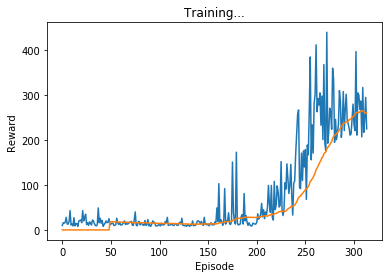

Target achieved in 313 episodes


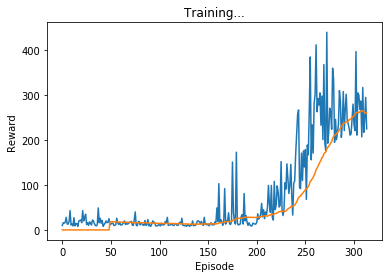

In [9]:
agent = Agent(0.0001, env.action_space.n)
run_training_loop(agent)


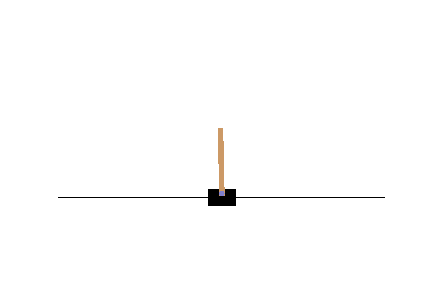
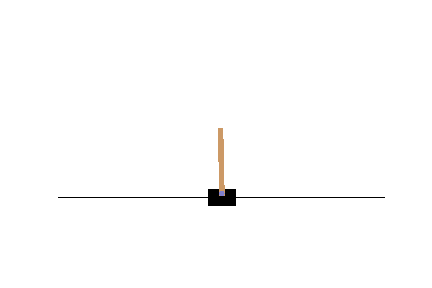
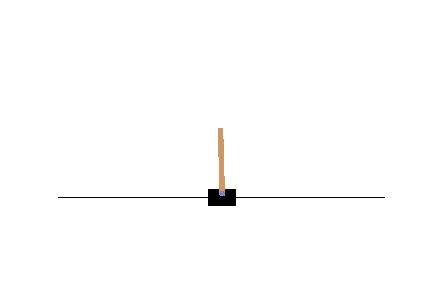
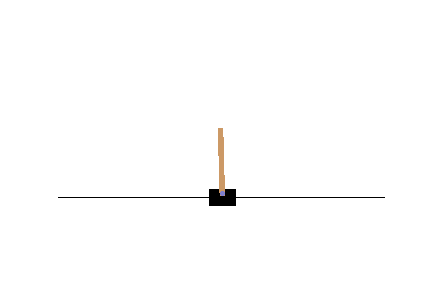
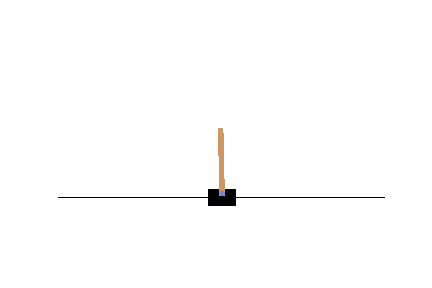
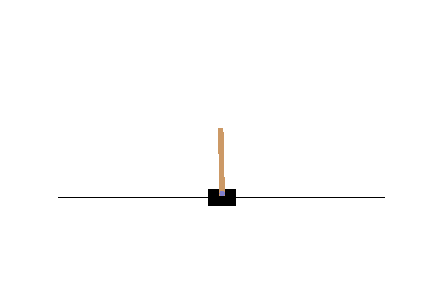
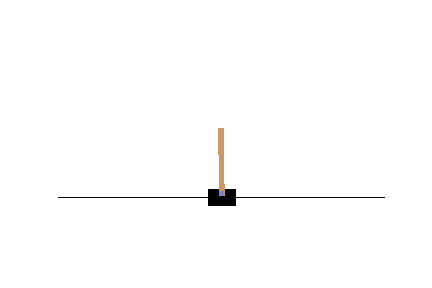
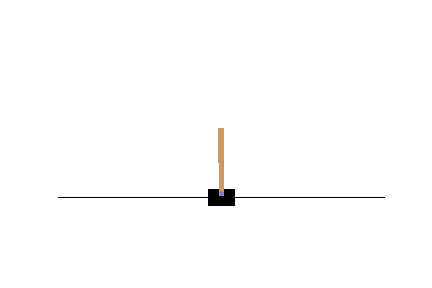
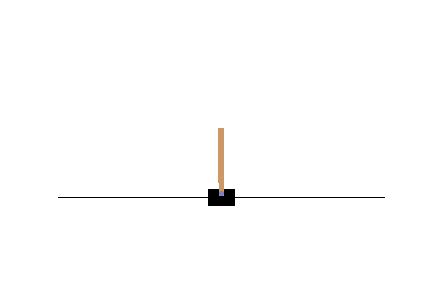
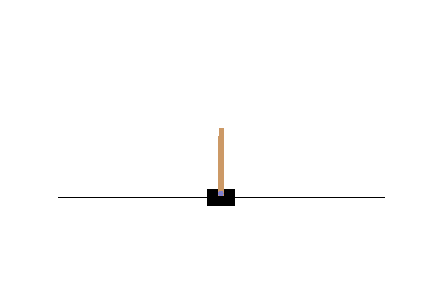
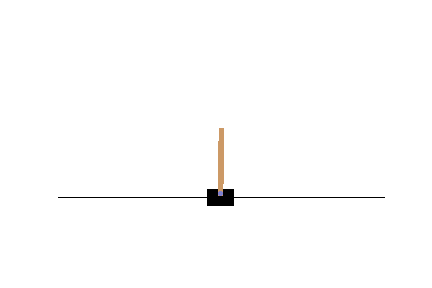
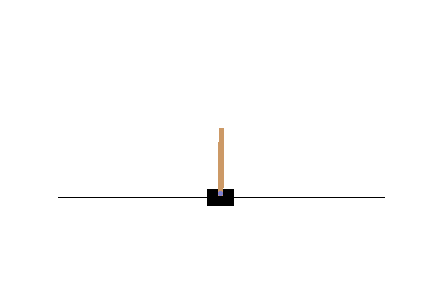
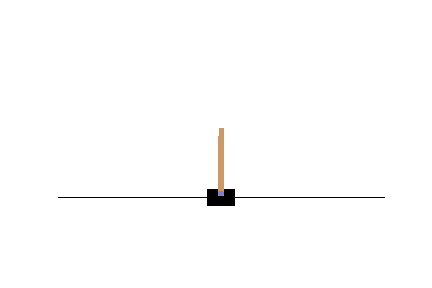
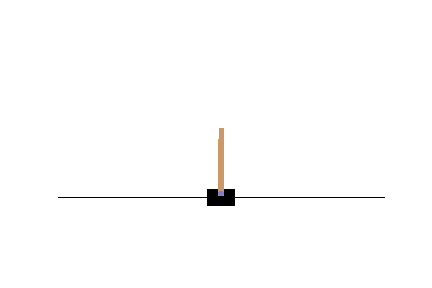
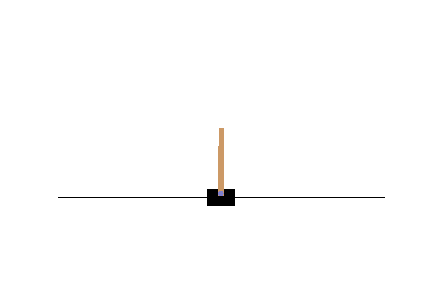
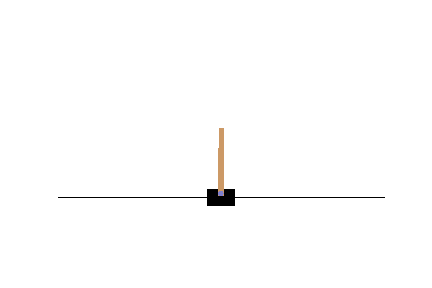
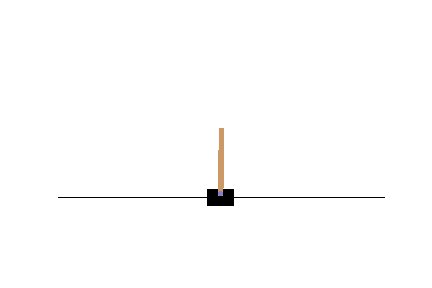
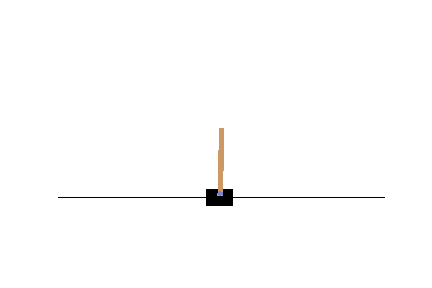
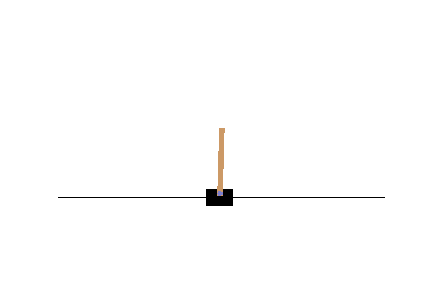
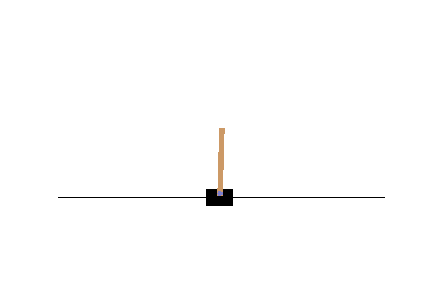
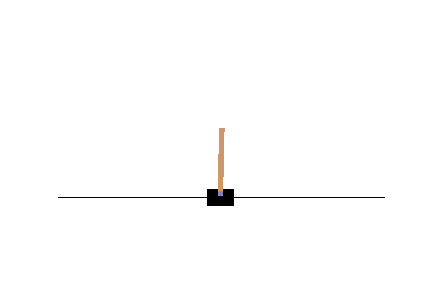
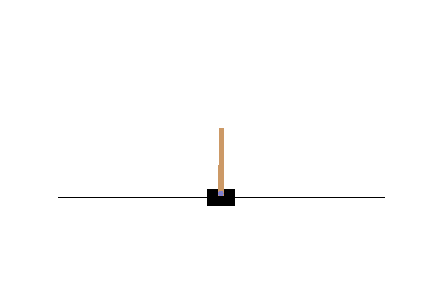
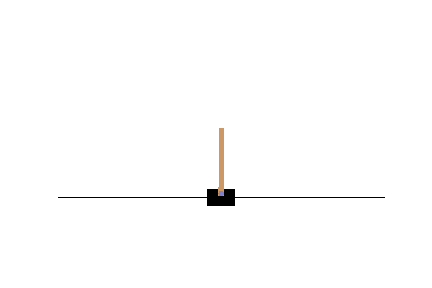
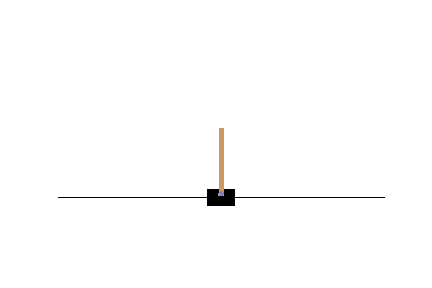
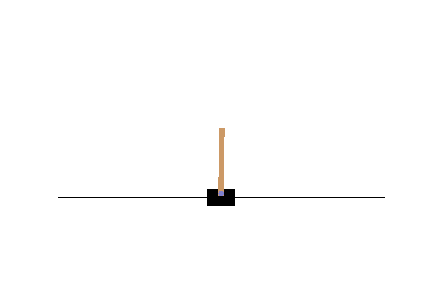
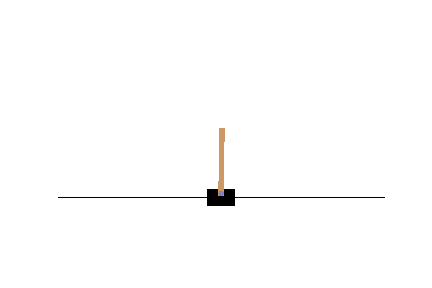
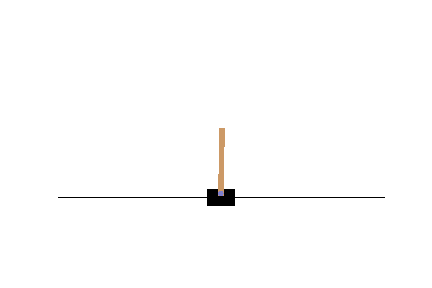
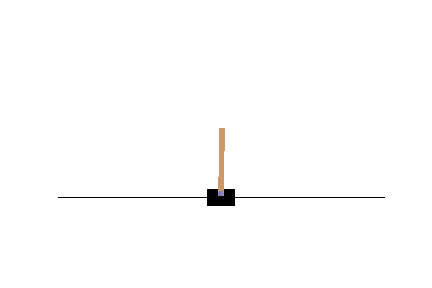
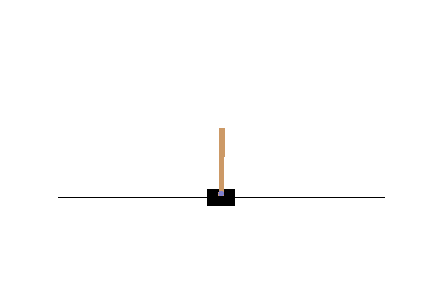
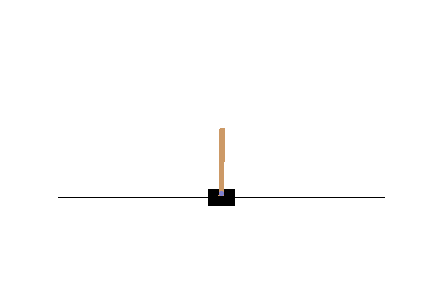
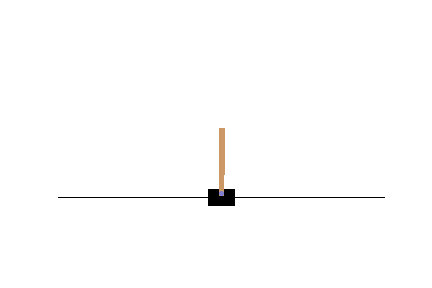
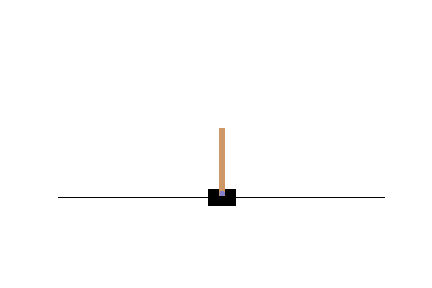
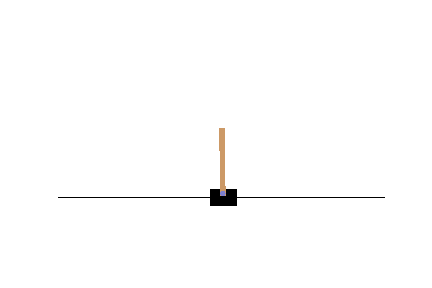
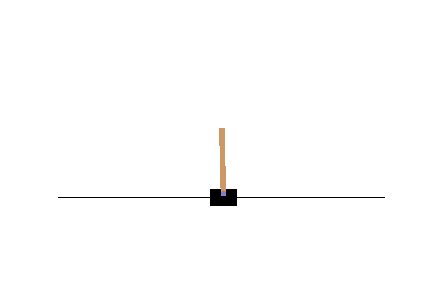
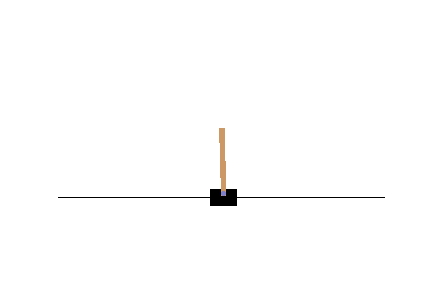
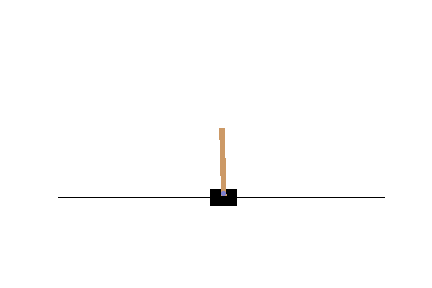
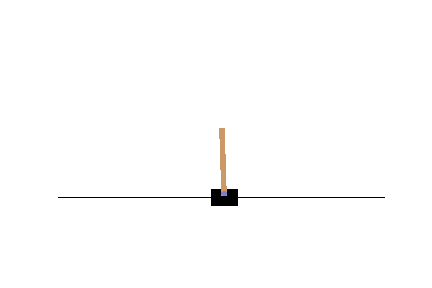
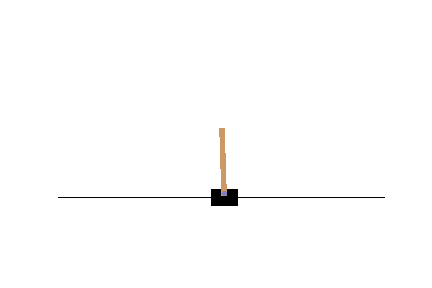
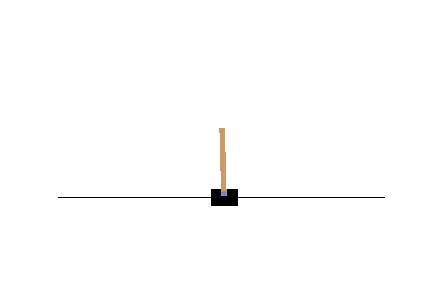
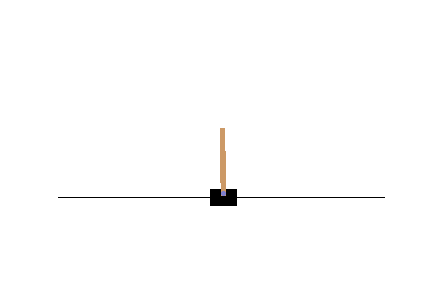
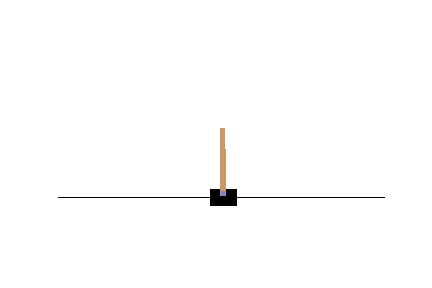
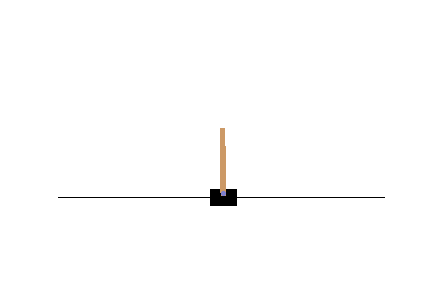
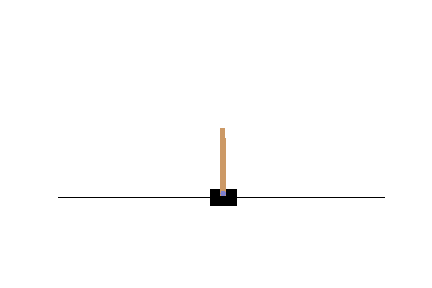
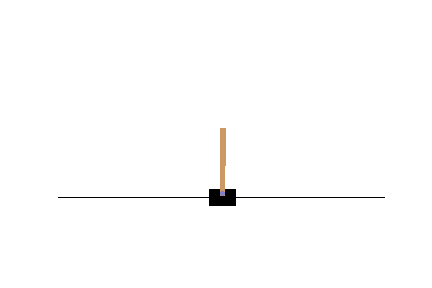
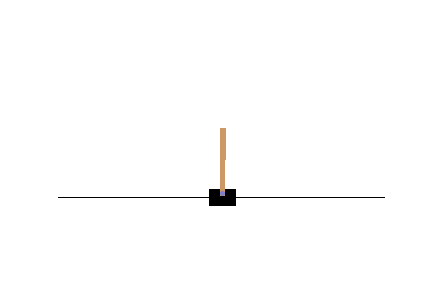
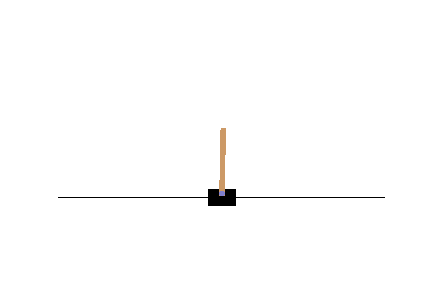
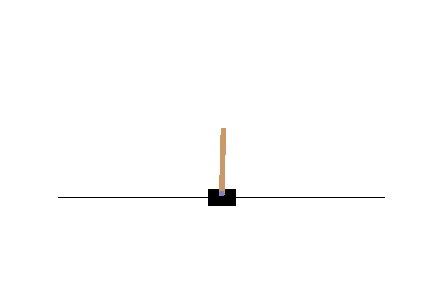
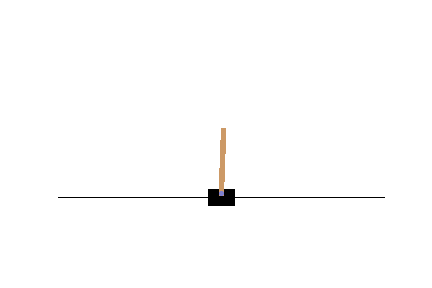
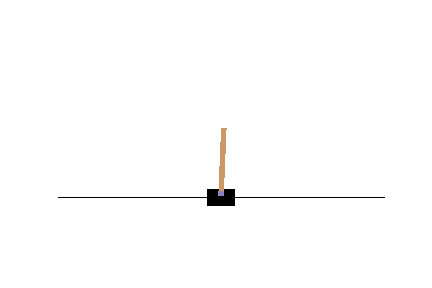
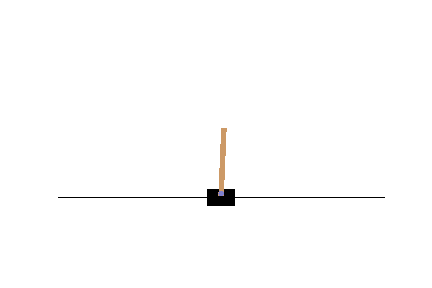
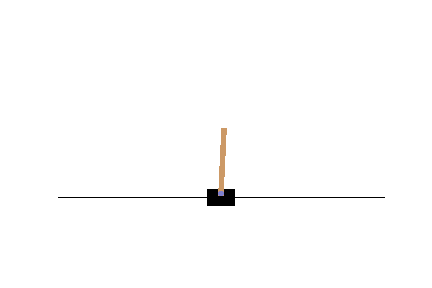
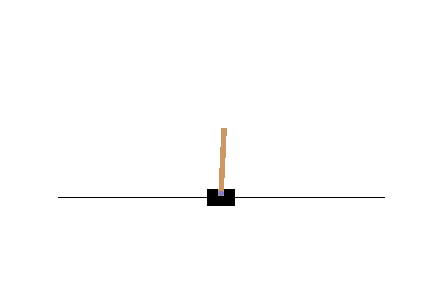
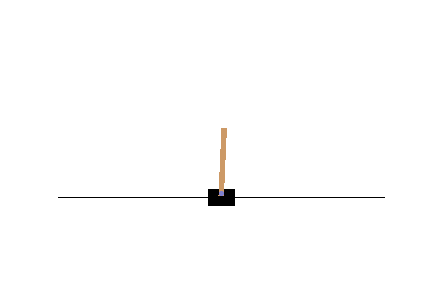
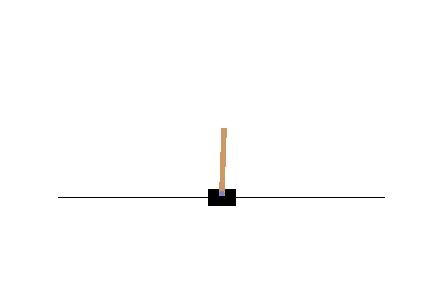
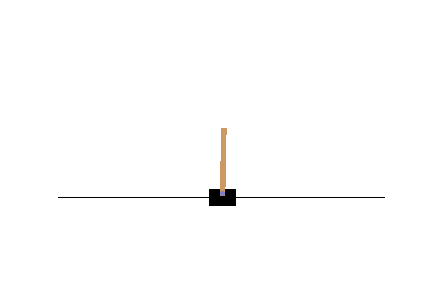
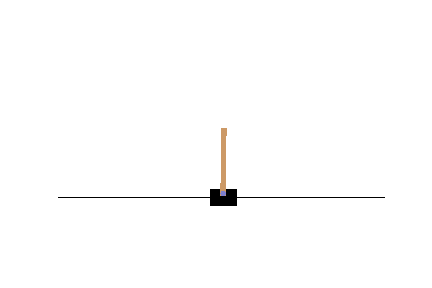
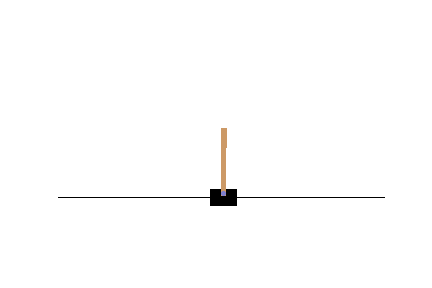
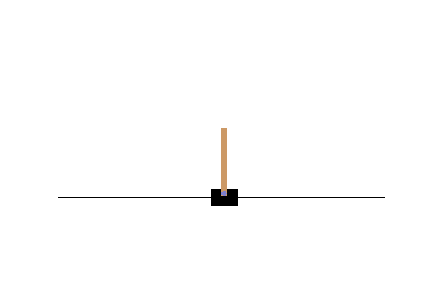
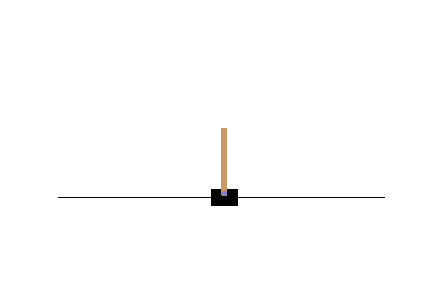
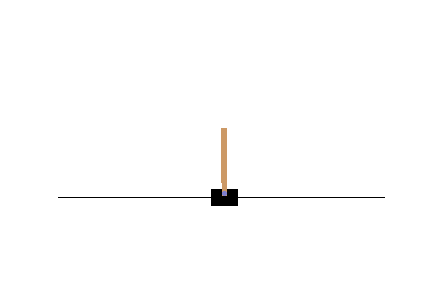
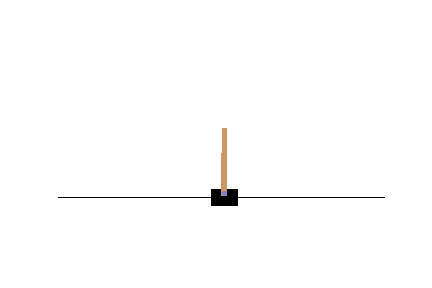
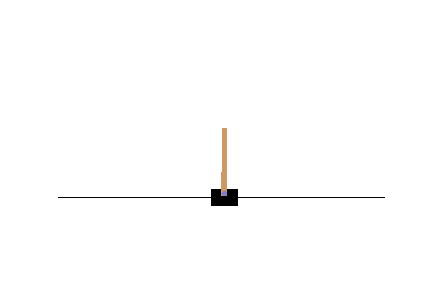
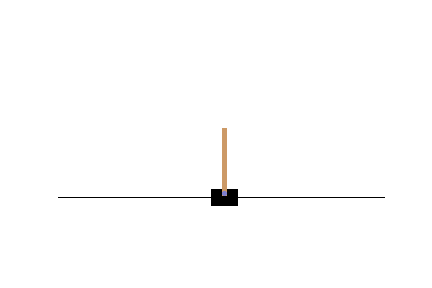
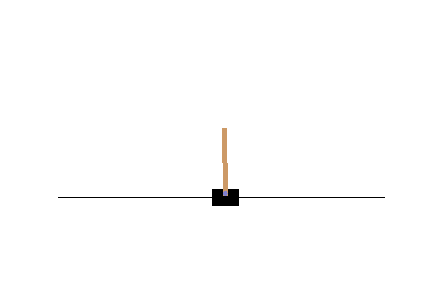
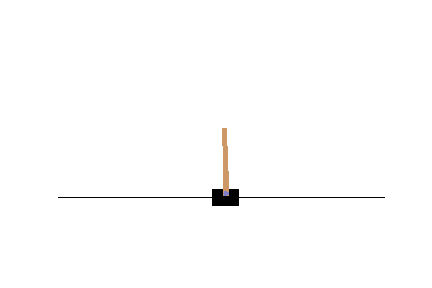
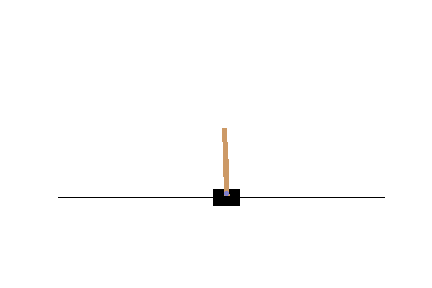
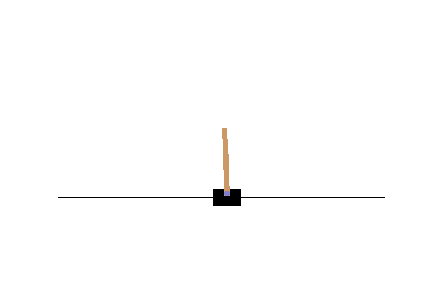
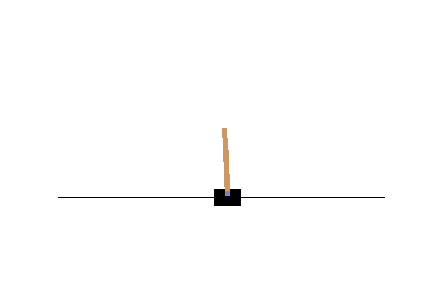
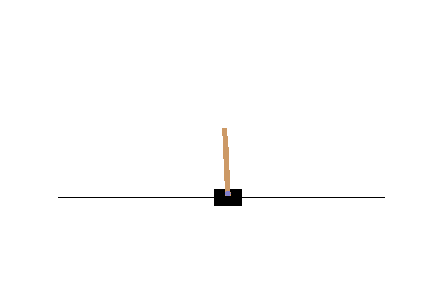
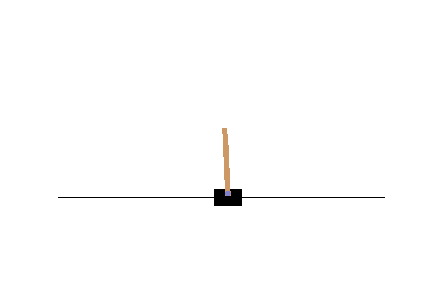
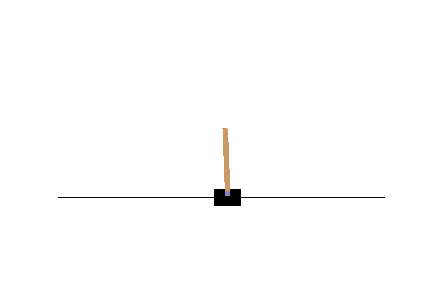
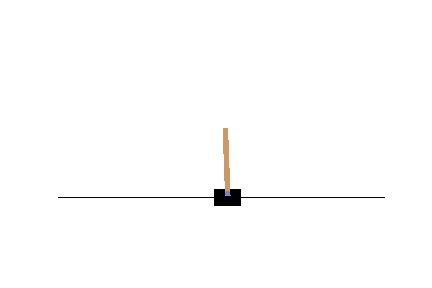
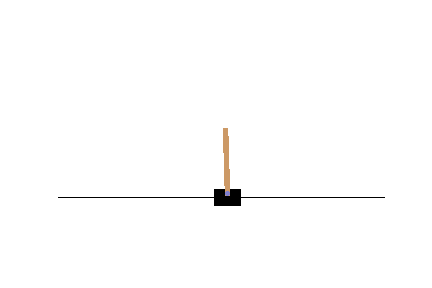
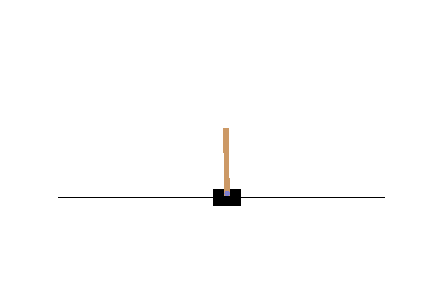
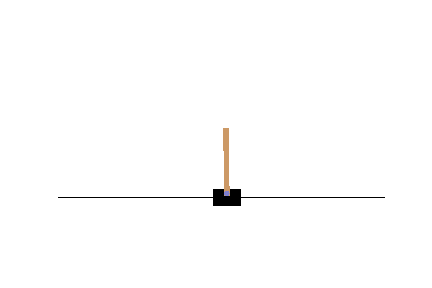
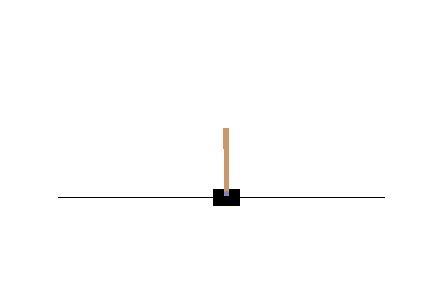
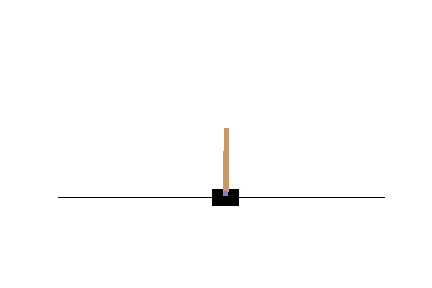
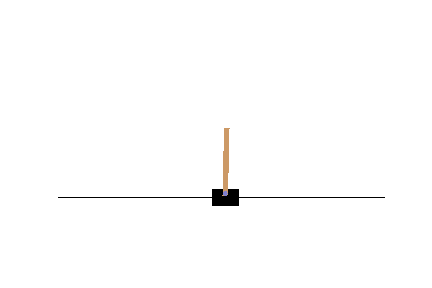
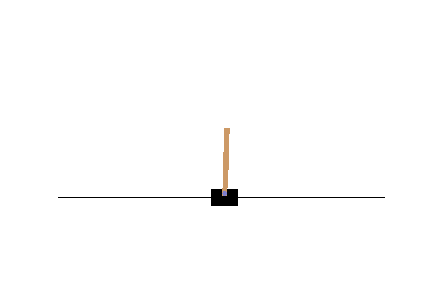
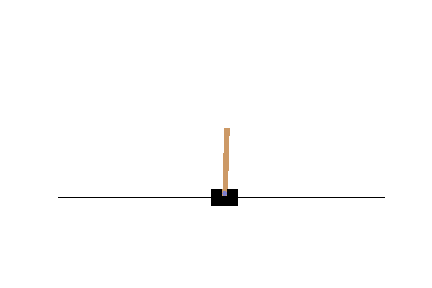
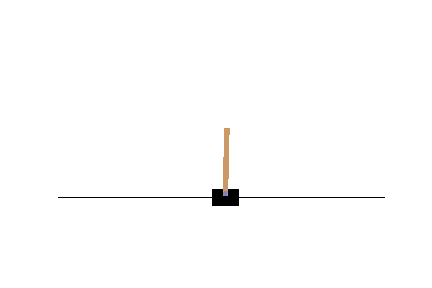
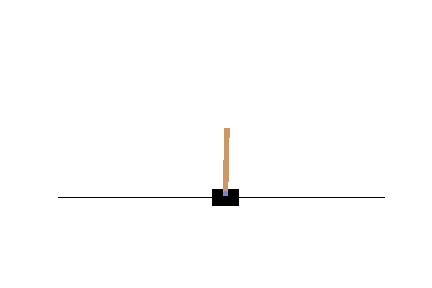
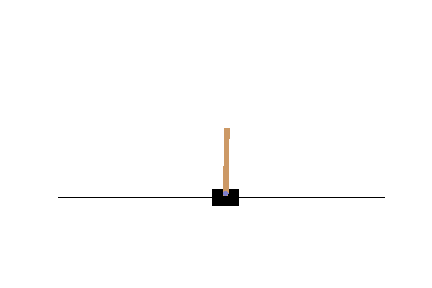
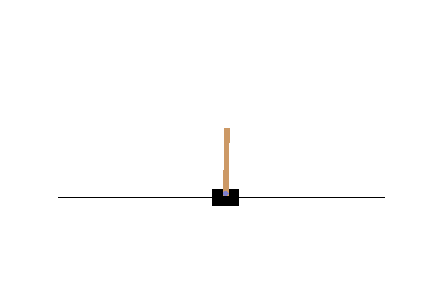
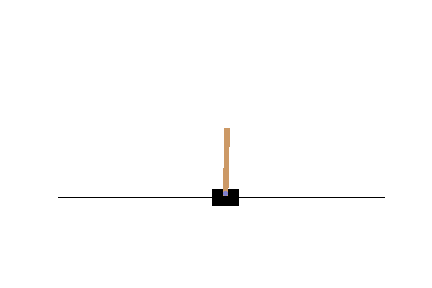
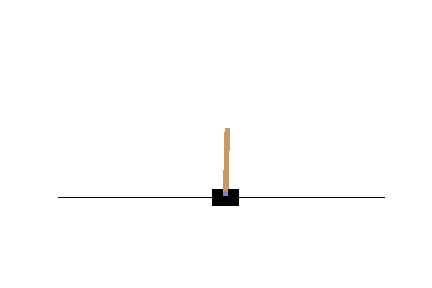
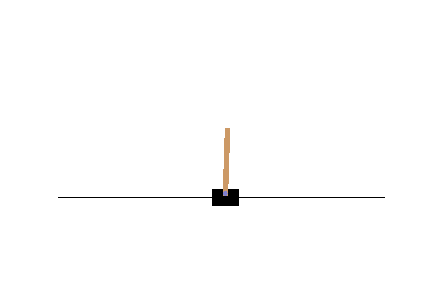
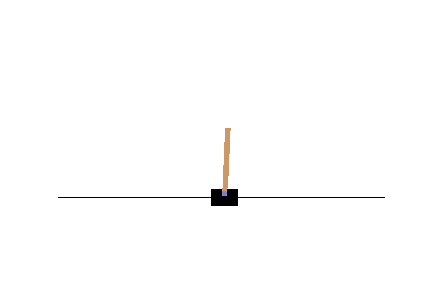
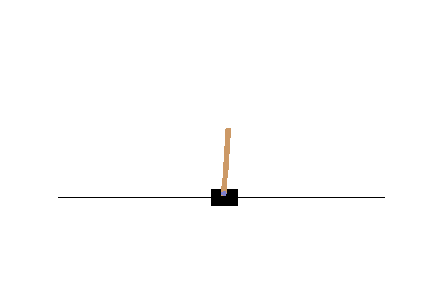
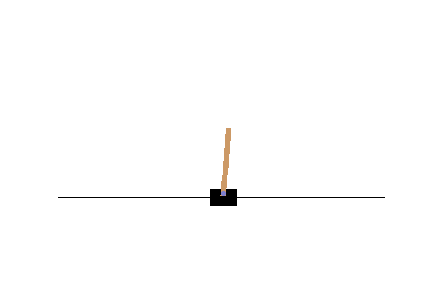
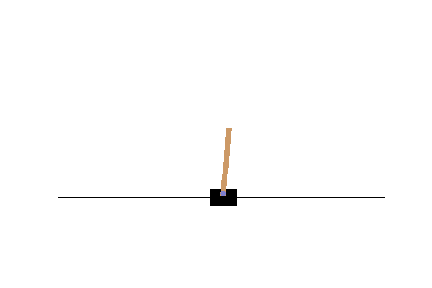
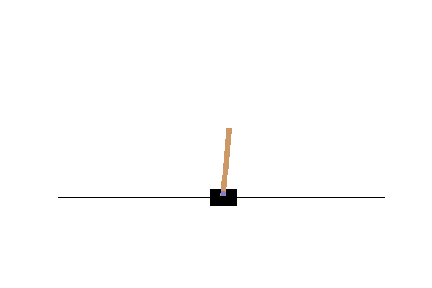
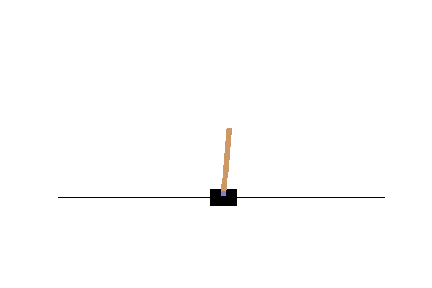
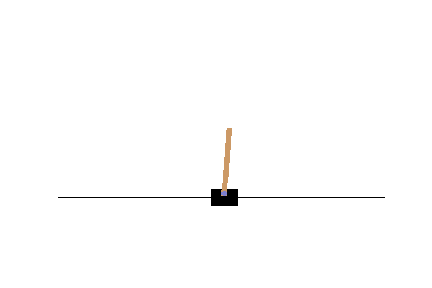
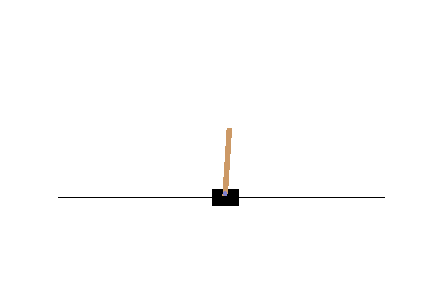
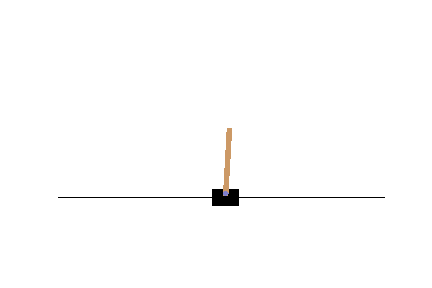
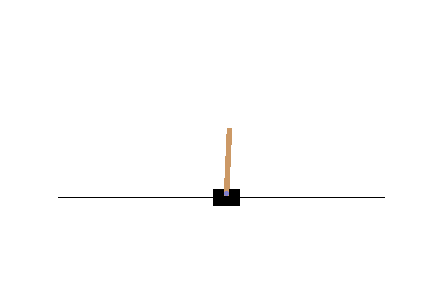
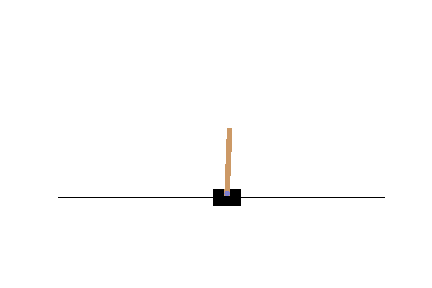
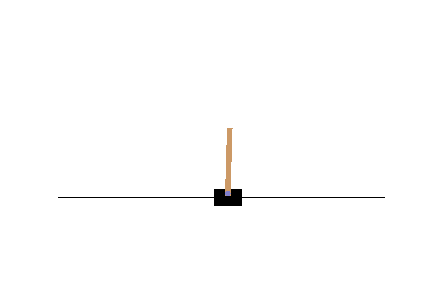
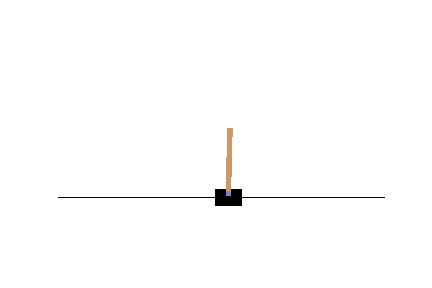
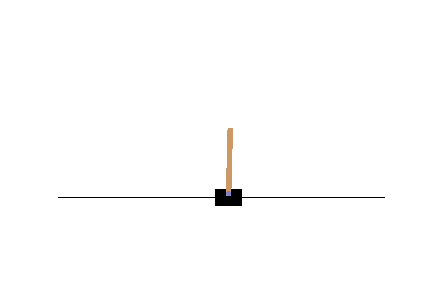
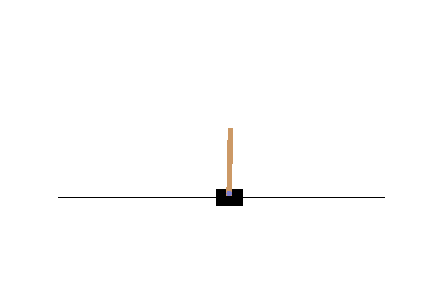
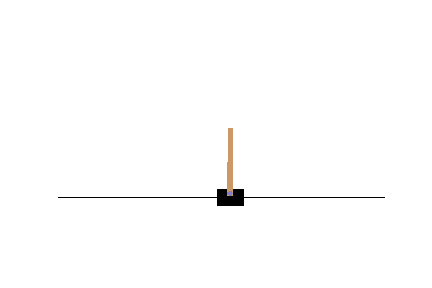
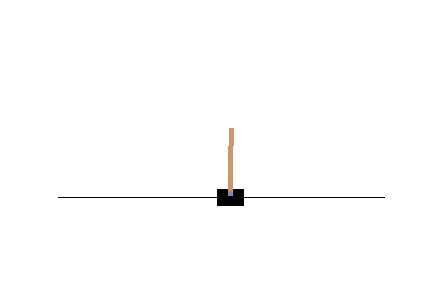
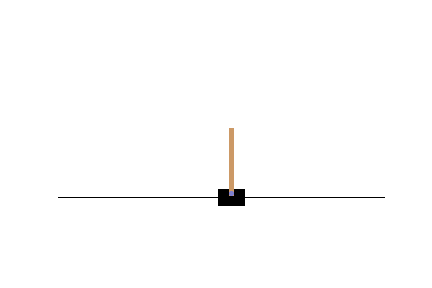
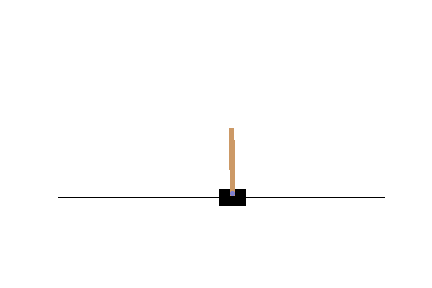
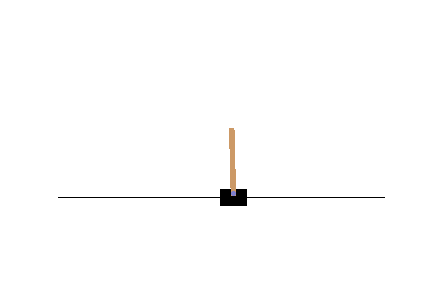
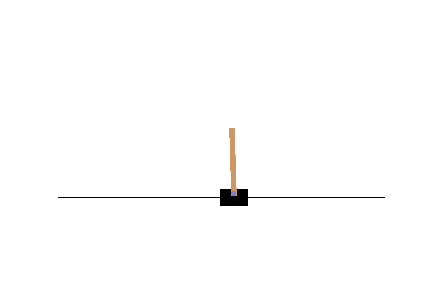
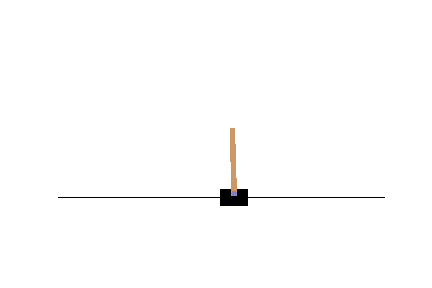
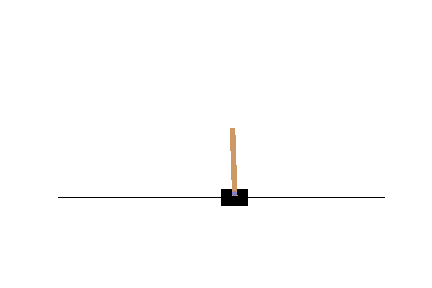
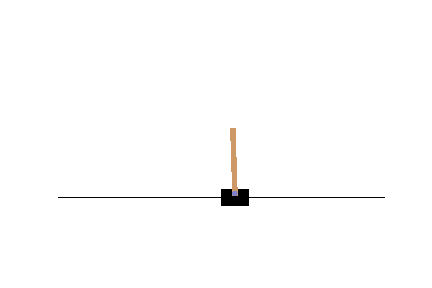
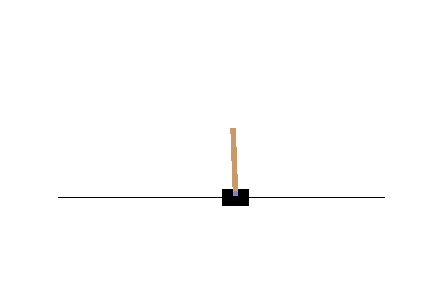
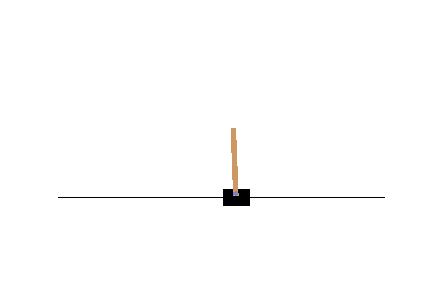
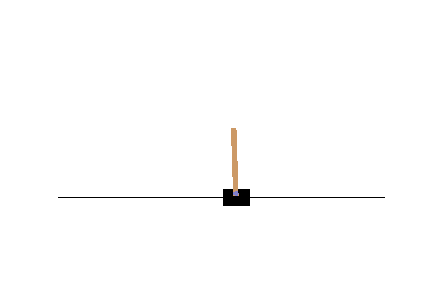
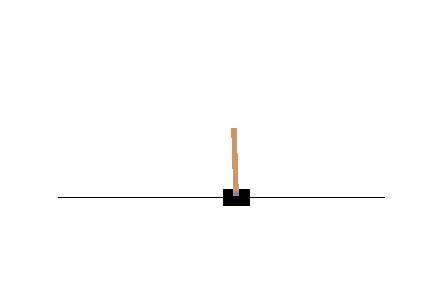
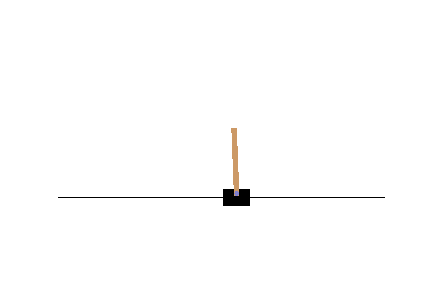
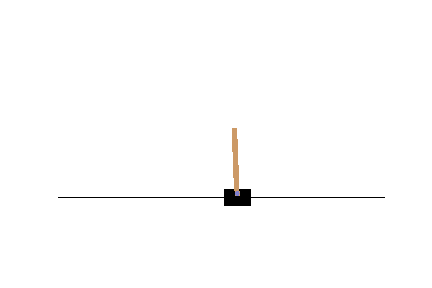
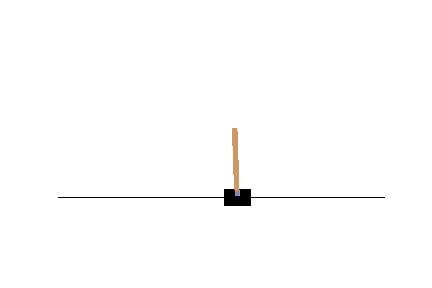
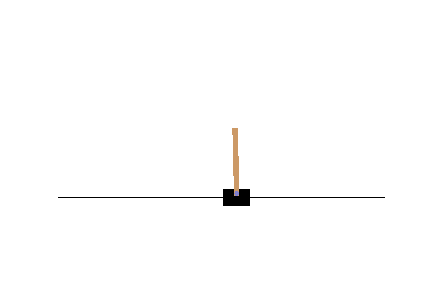
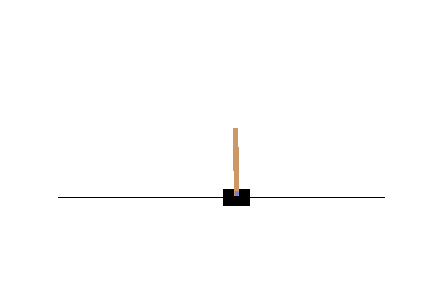
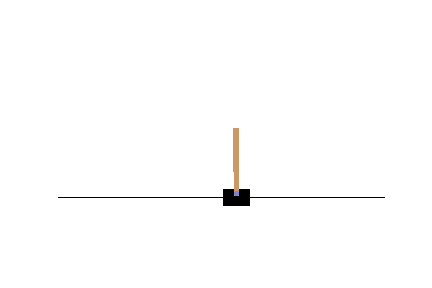
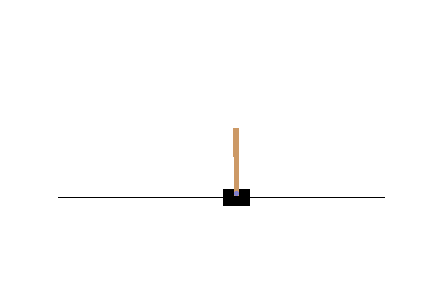
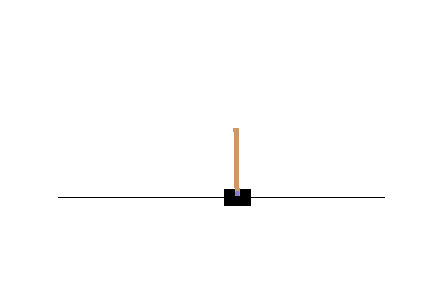
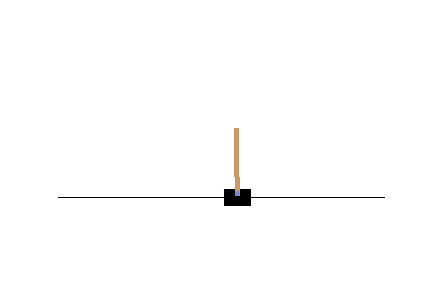
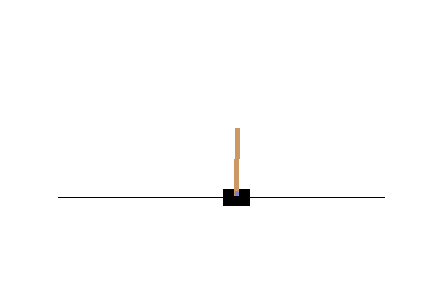
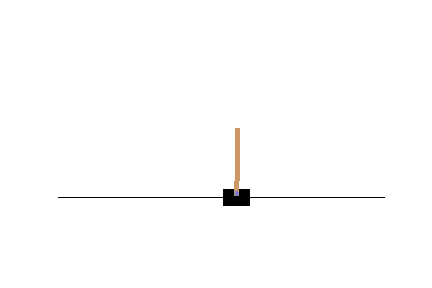
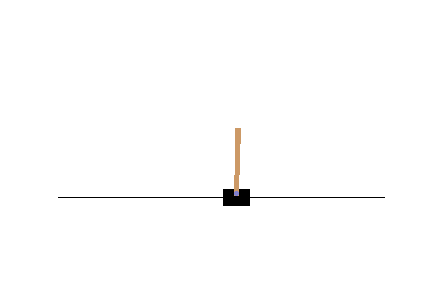
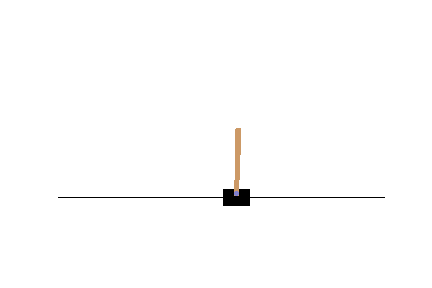
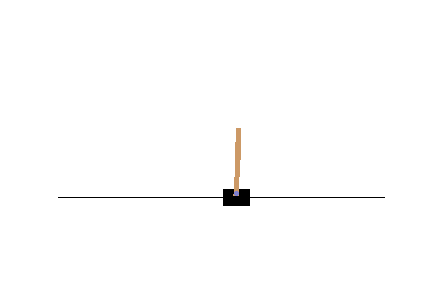
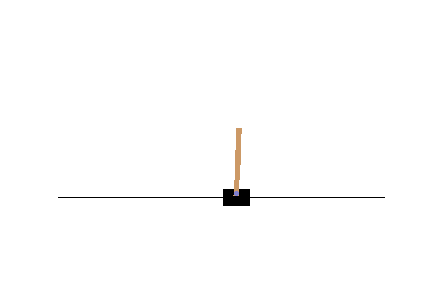
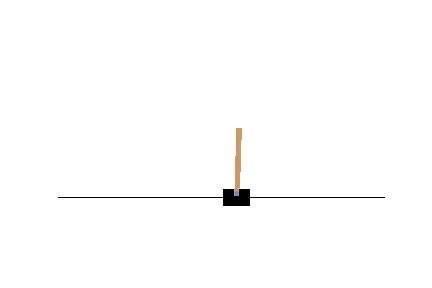
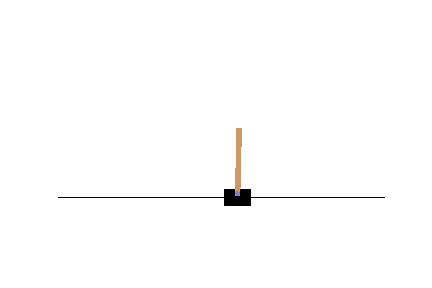
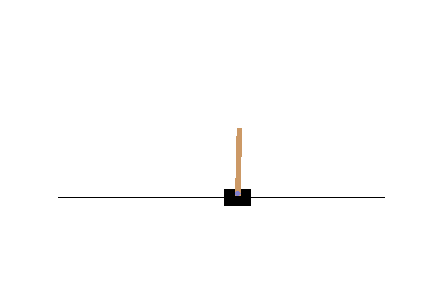
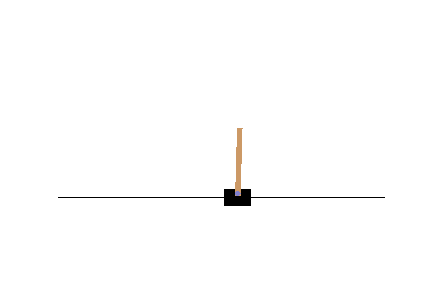
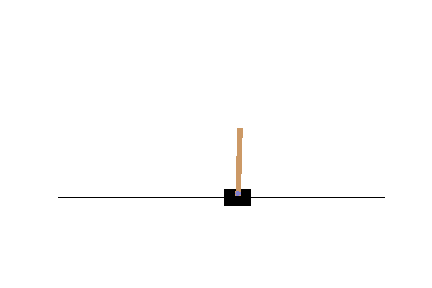
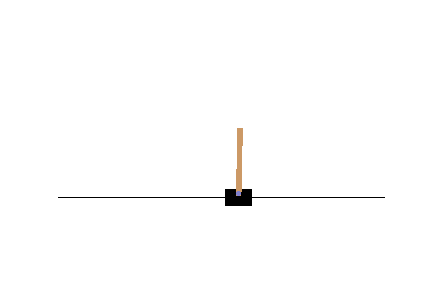
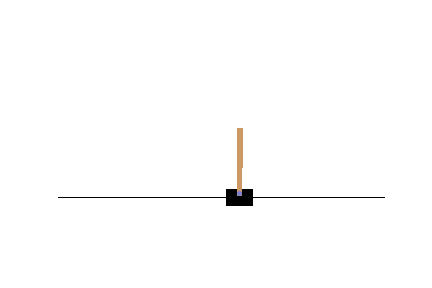
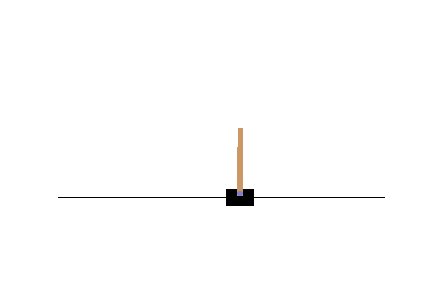
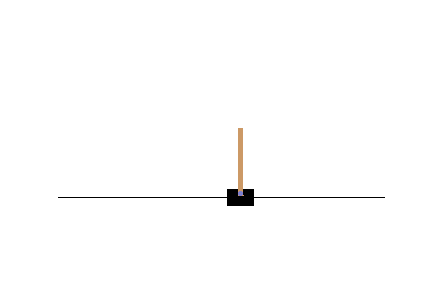
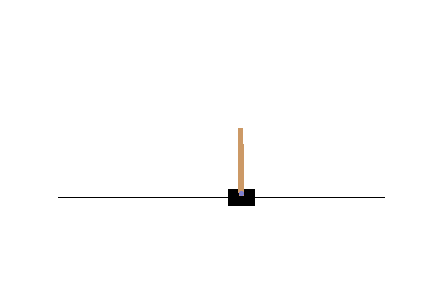
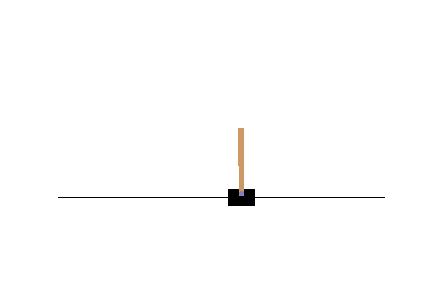
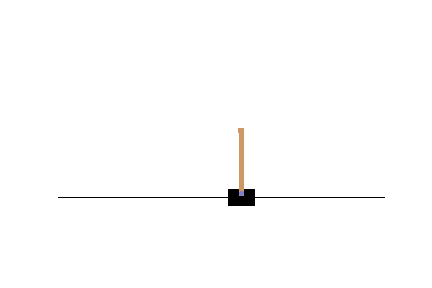
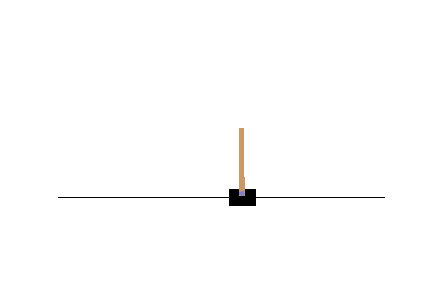
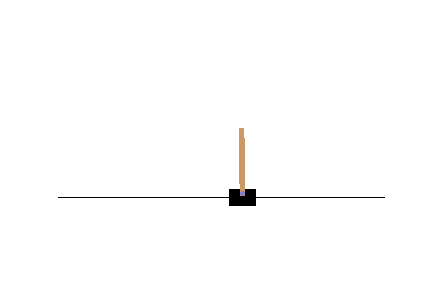
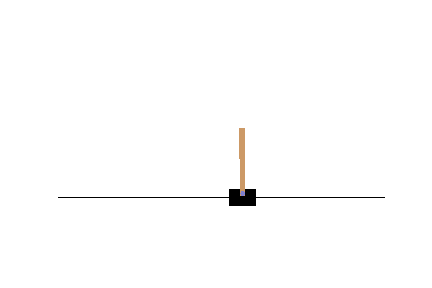
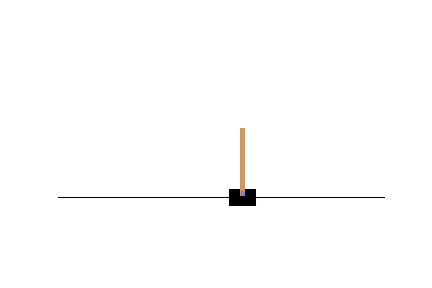
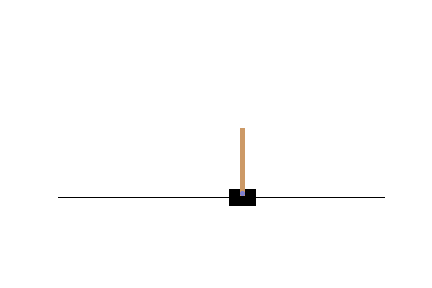
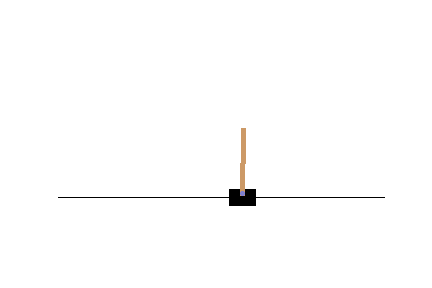
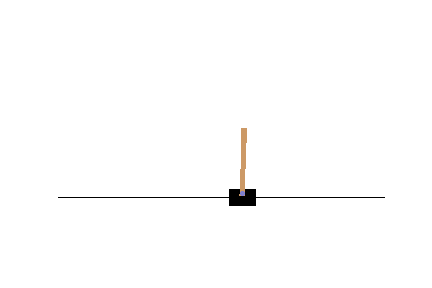
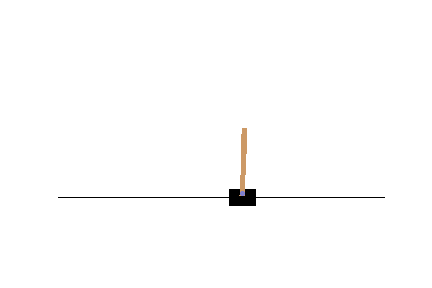
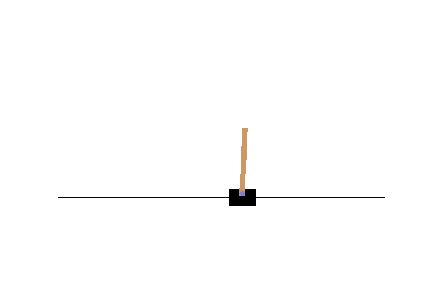
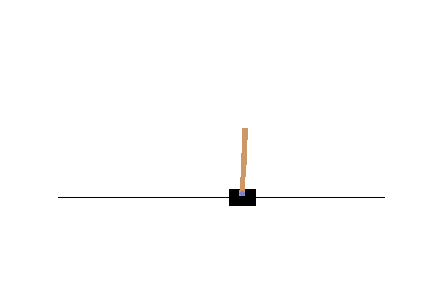
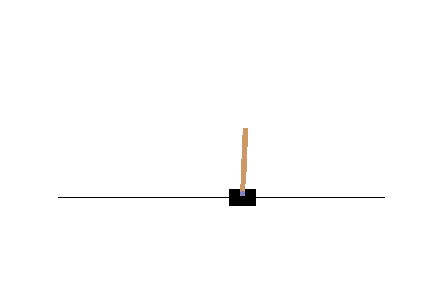
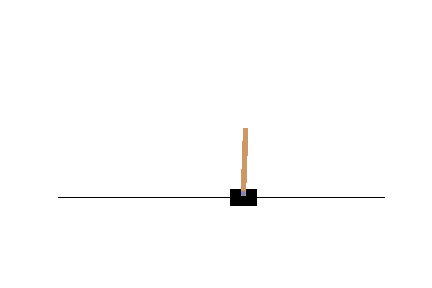
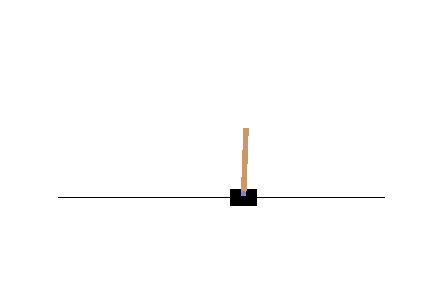
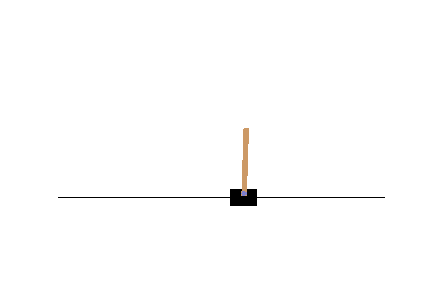
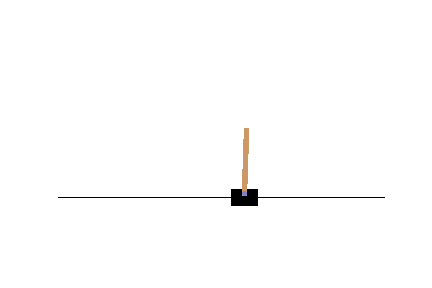
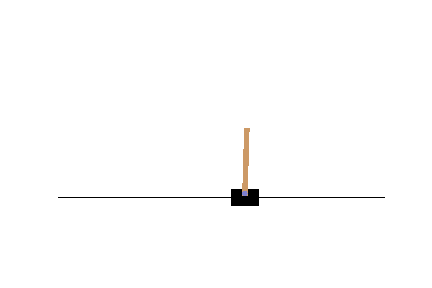
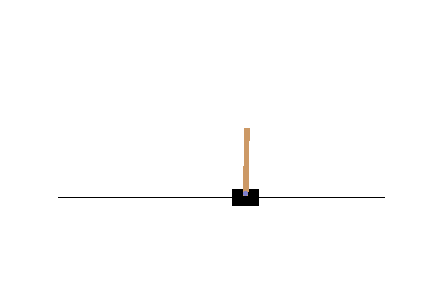
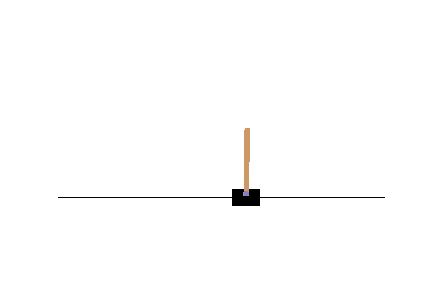
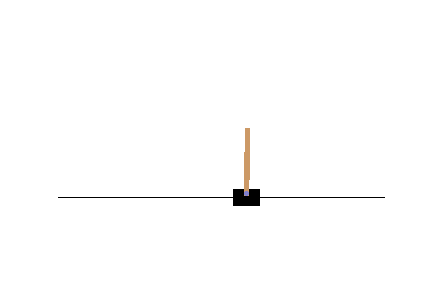
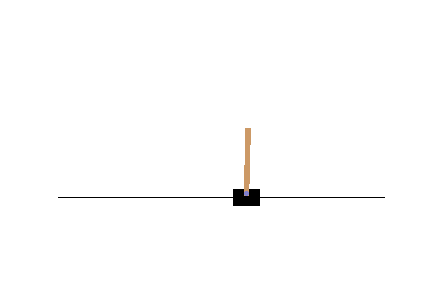
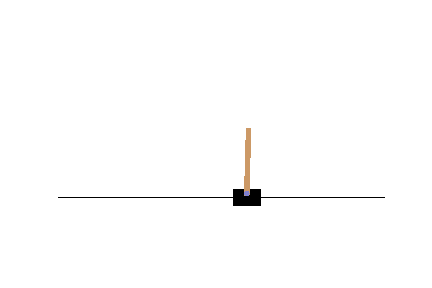
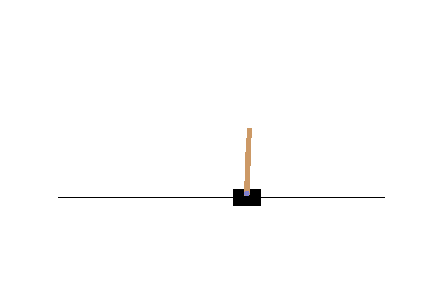
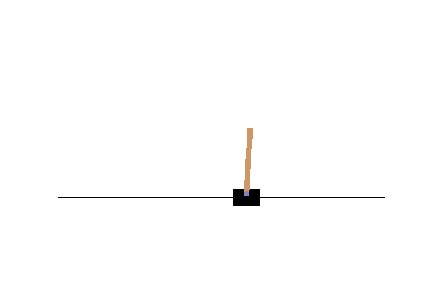
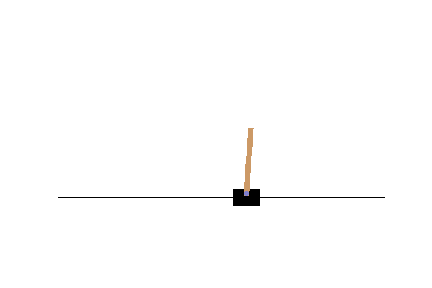
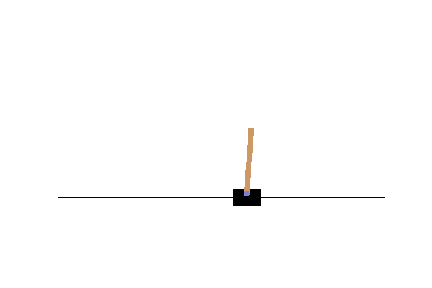
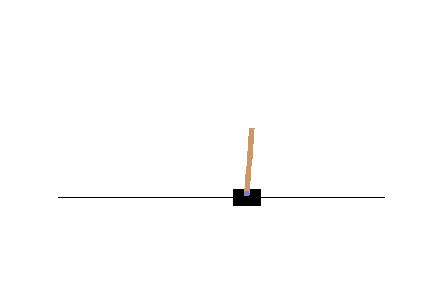
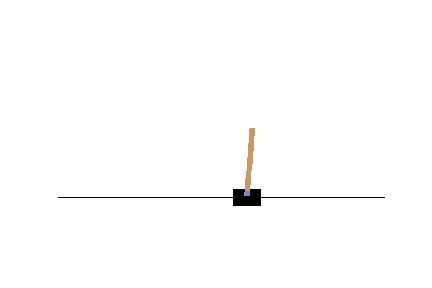
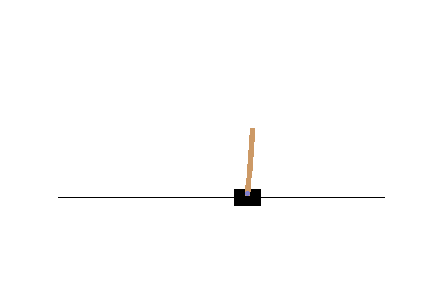
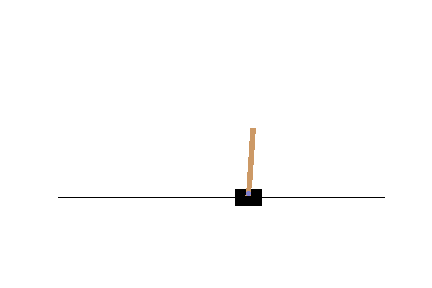
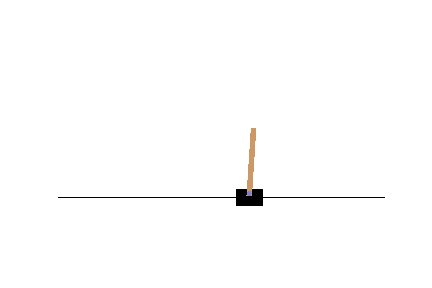
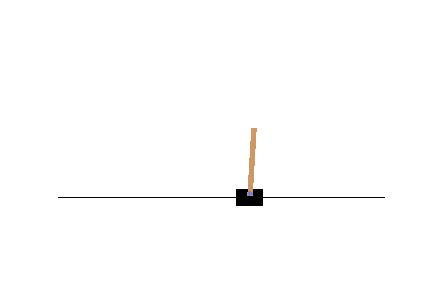
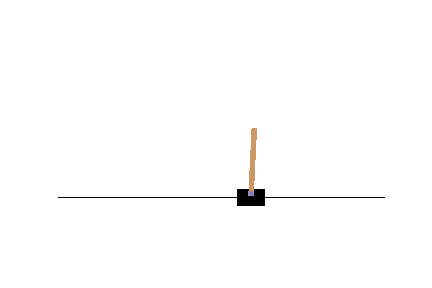
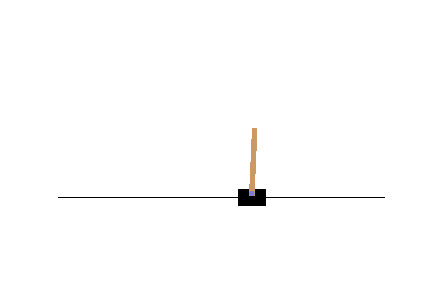
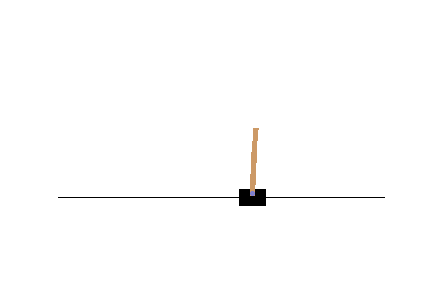
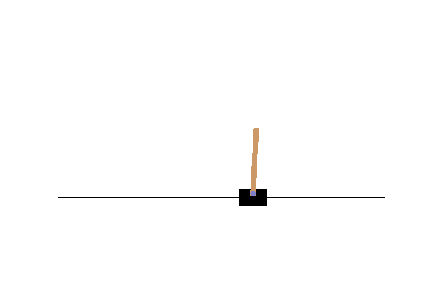
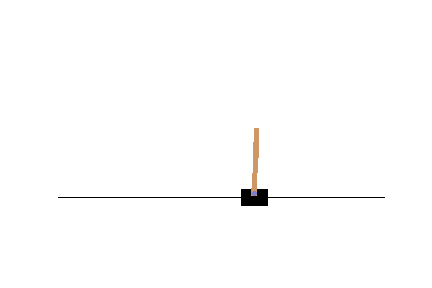
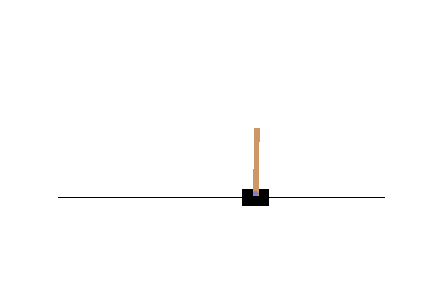
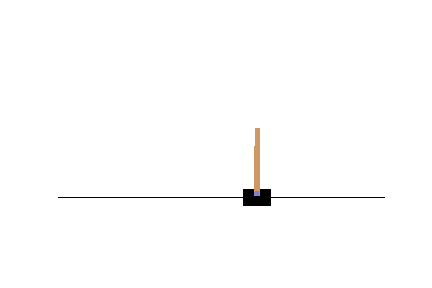
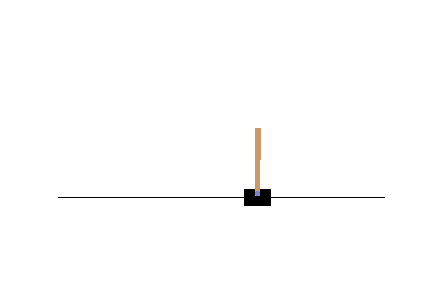
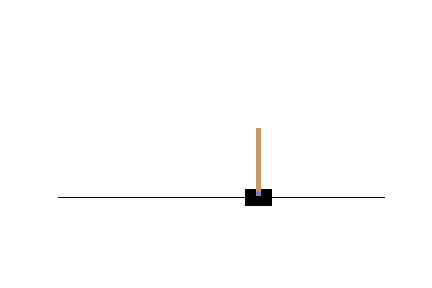
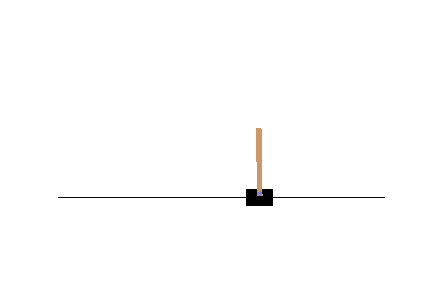
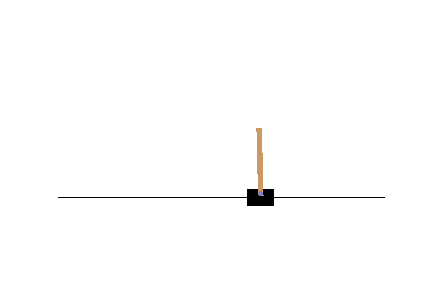
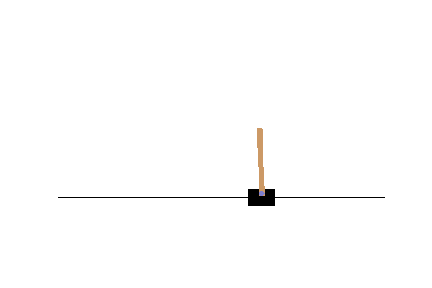
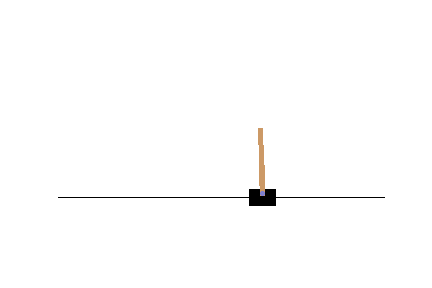
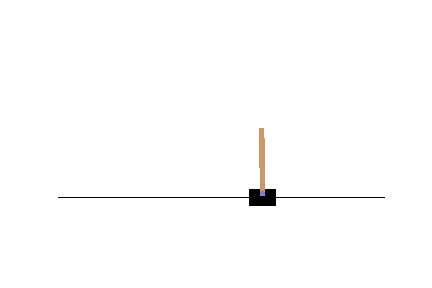
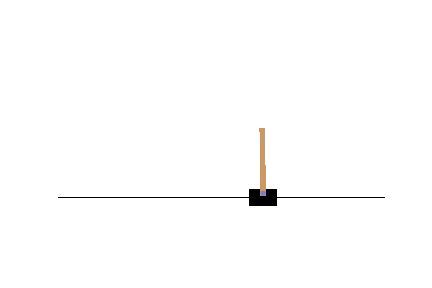
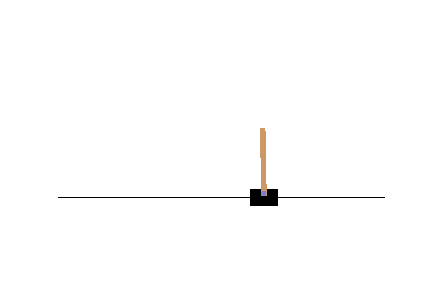
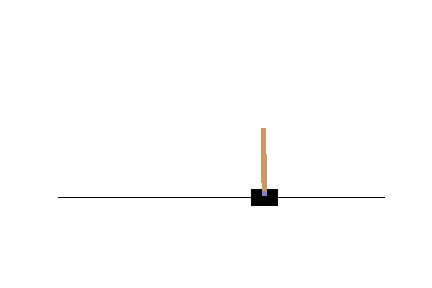
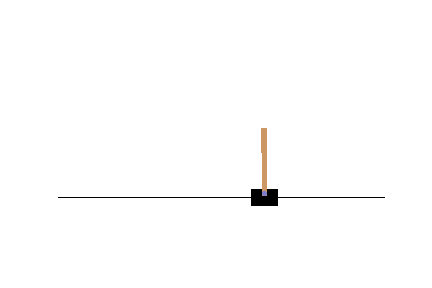
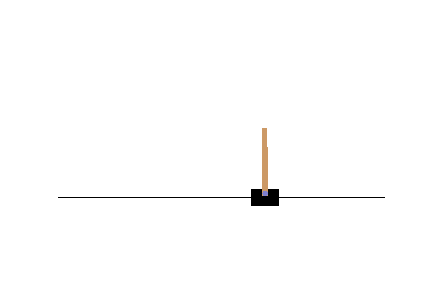
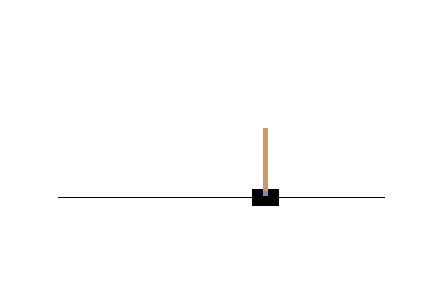
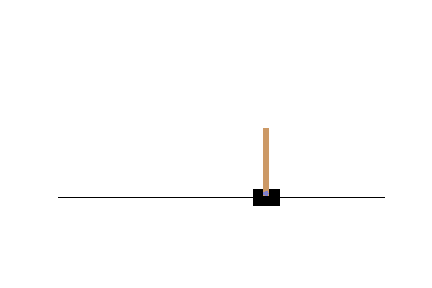
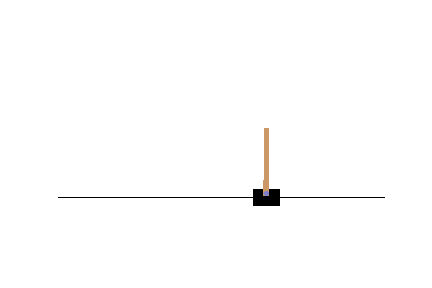
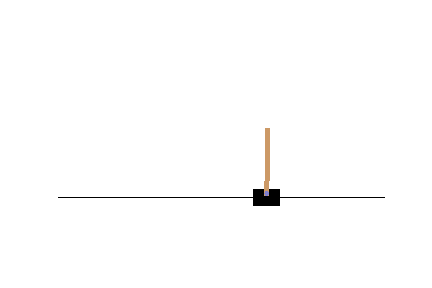
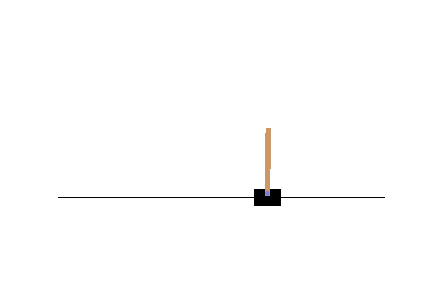
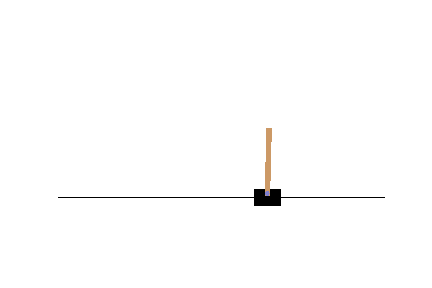
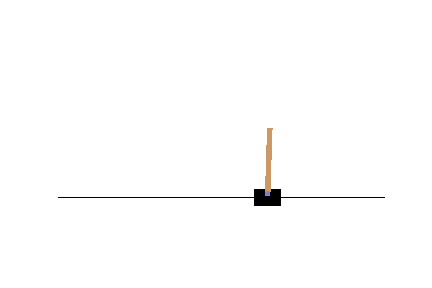
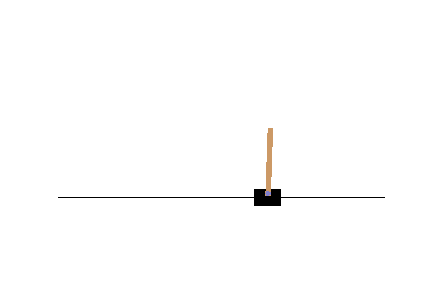
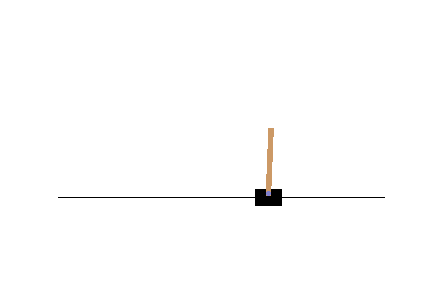
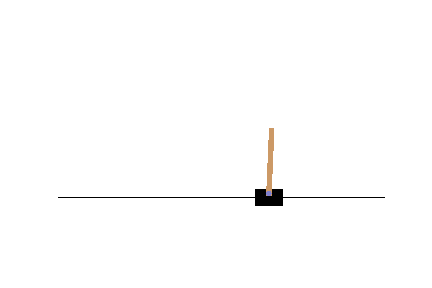
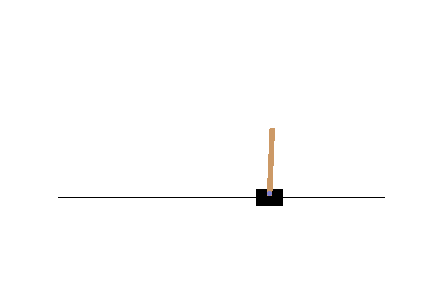
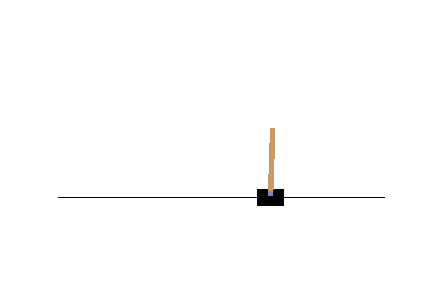
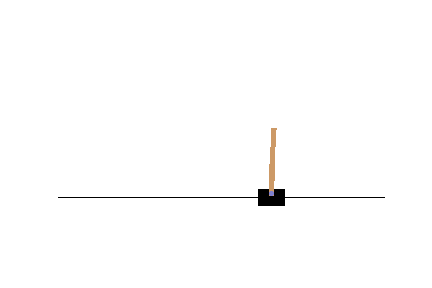
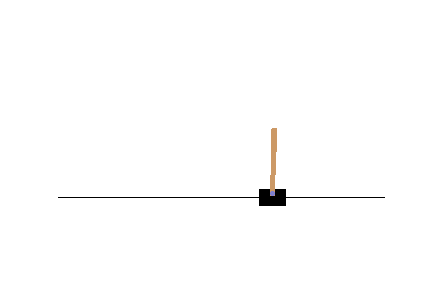
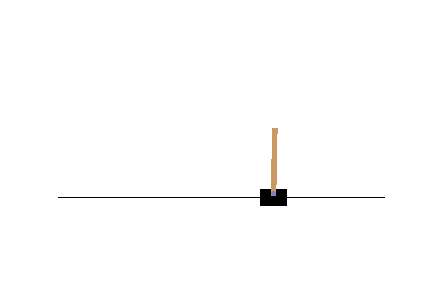
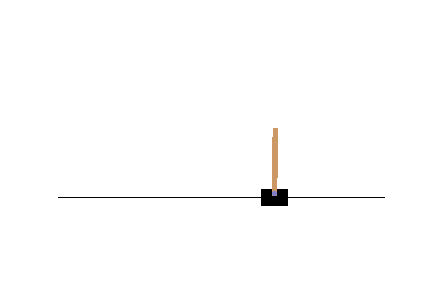
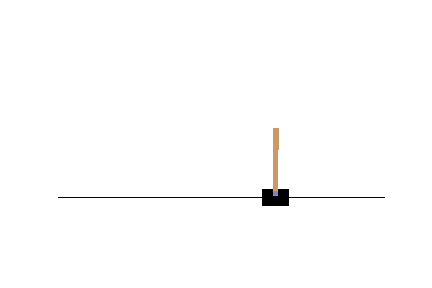
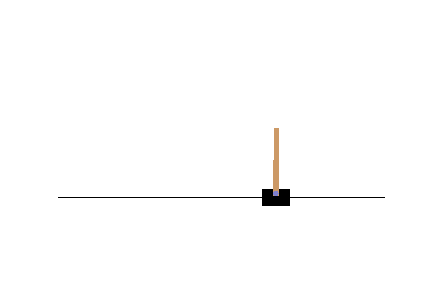
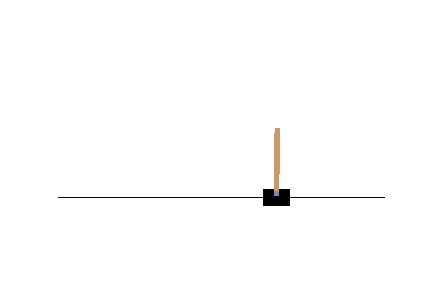
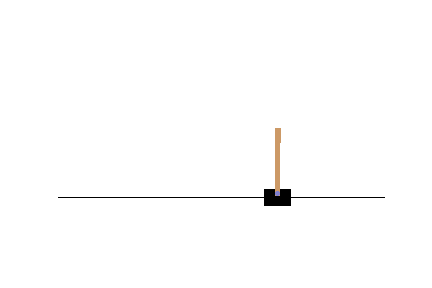
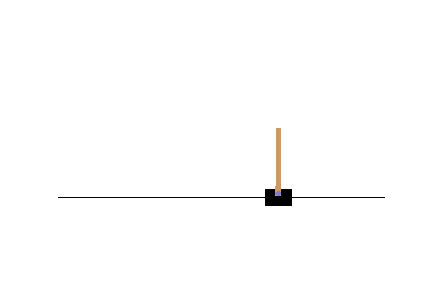
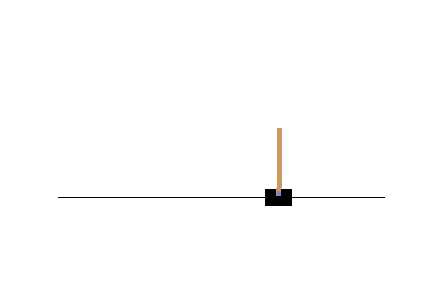
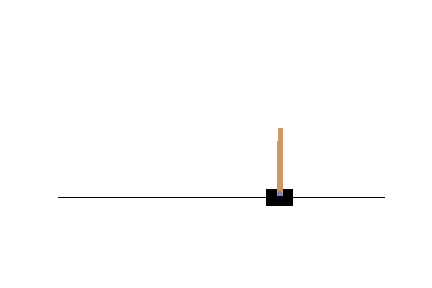
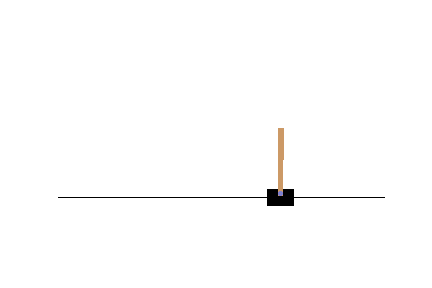
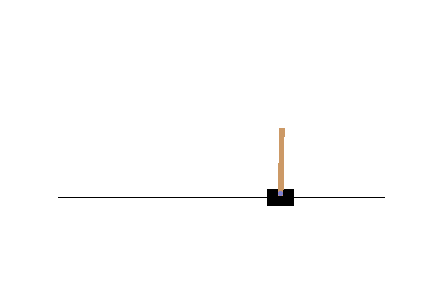
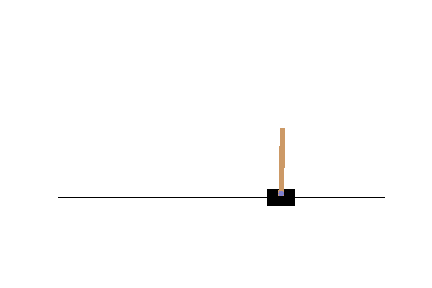
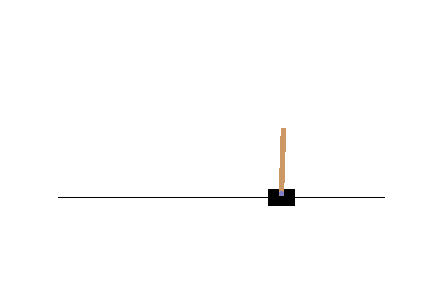
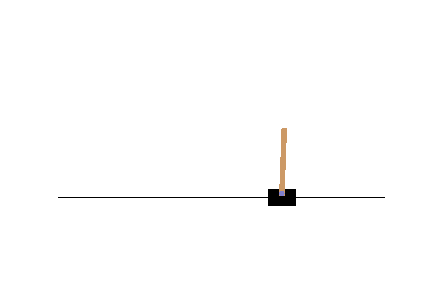
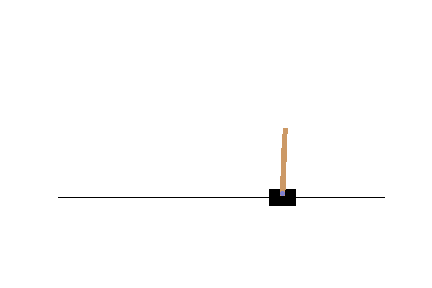
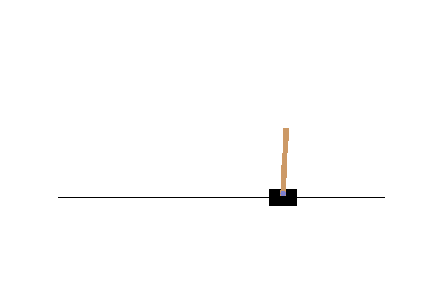
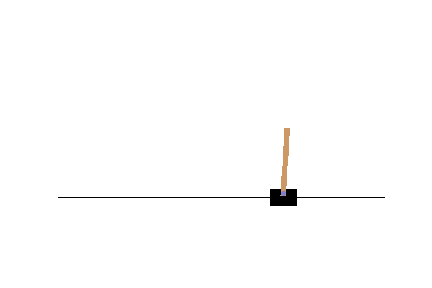
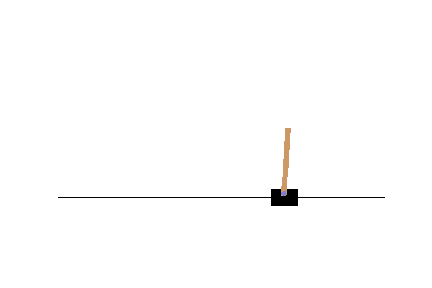
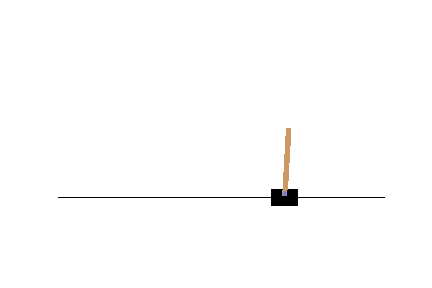
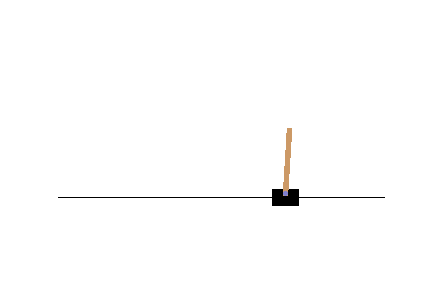
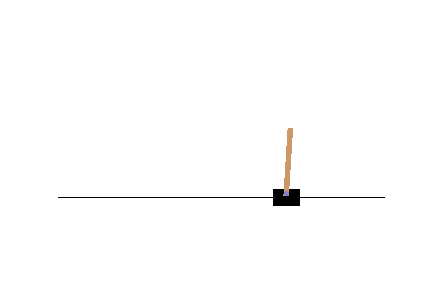
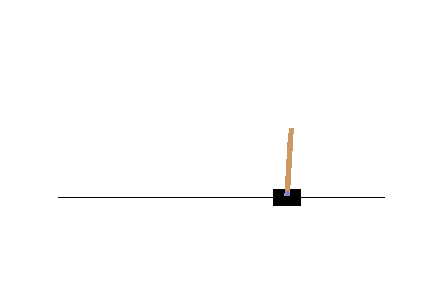
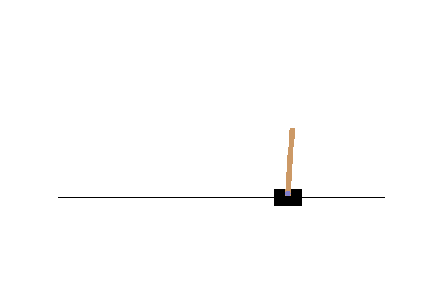
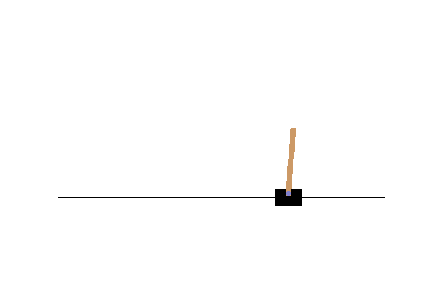
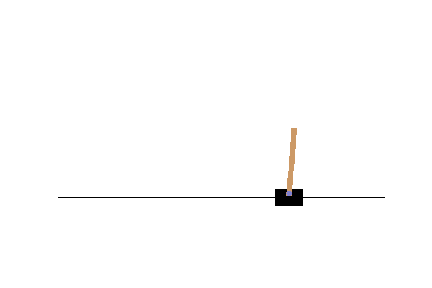
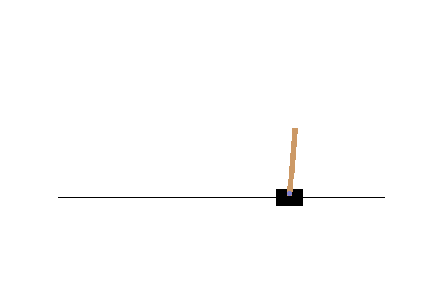
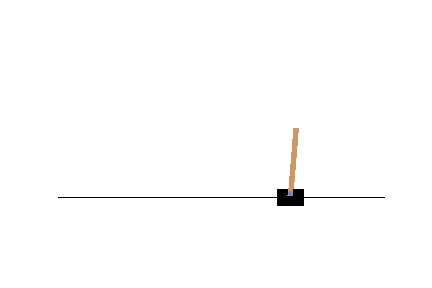
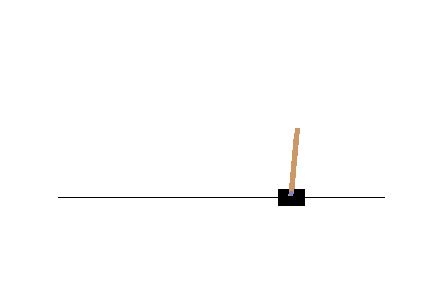
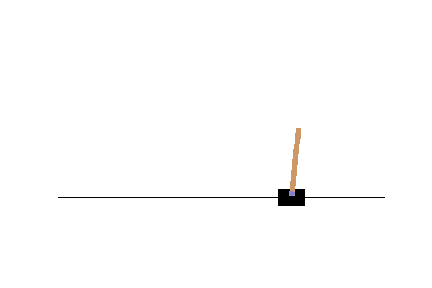
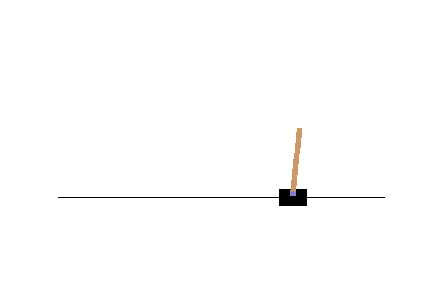
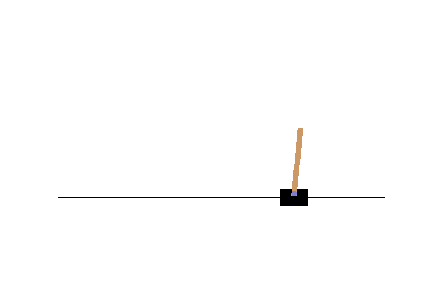
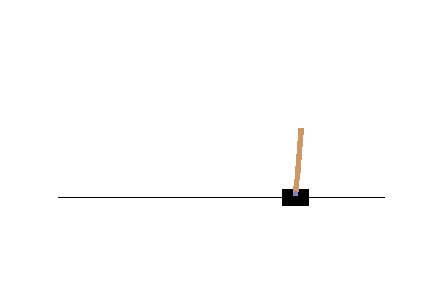
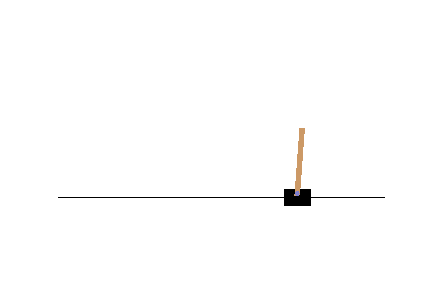
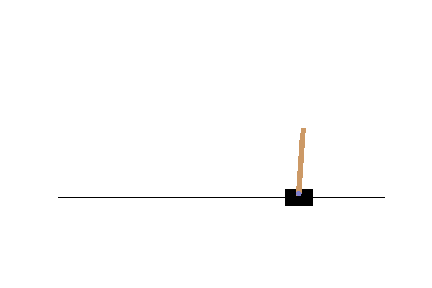
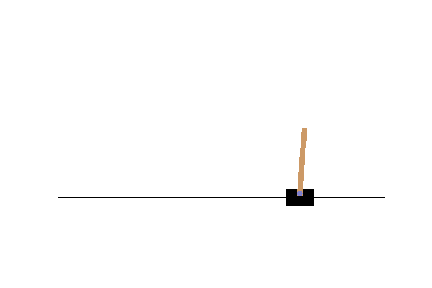
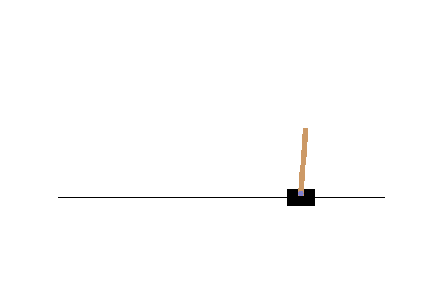
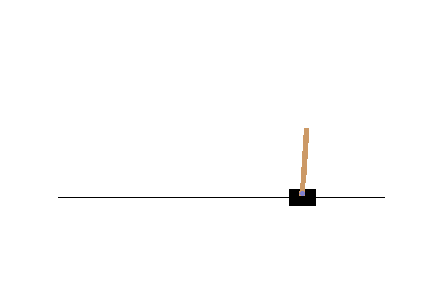
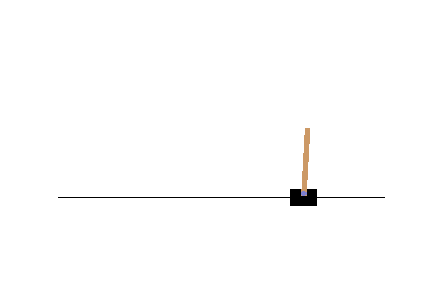
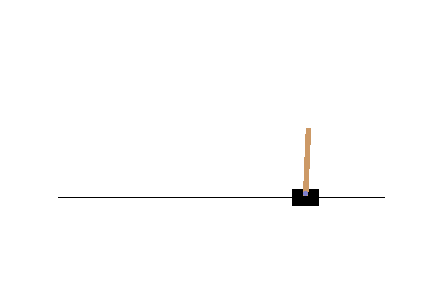
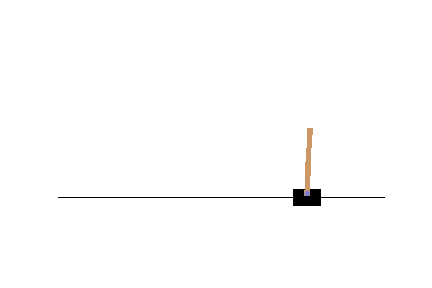
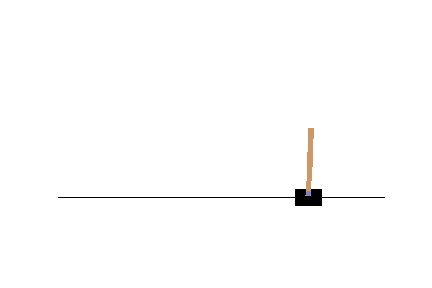
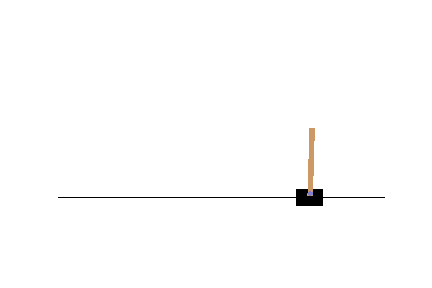
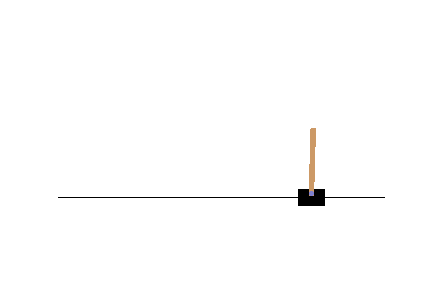
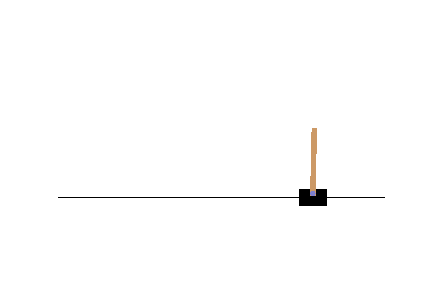
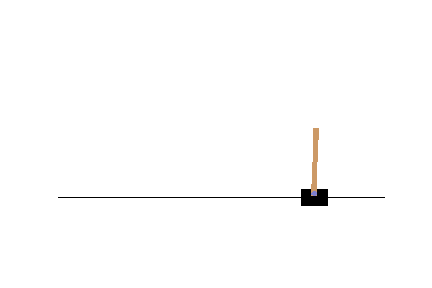
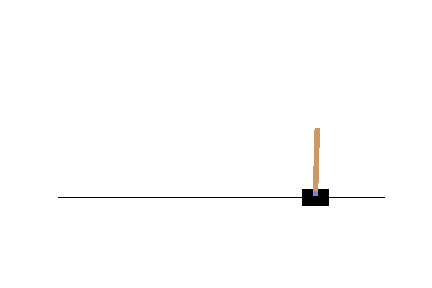
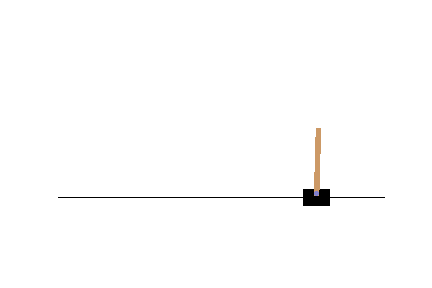
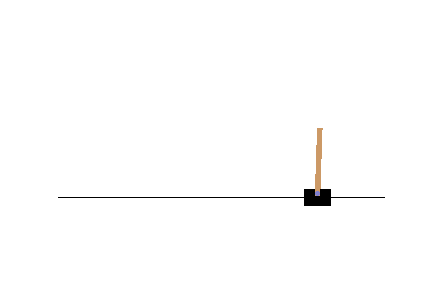
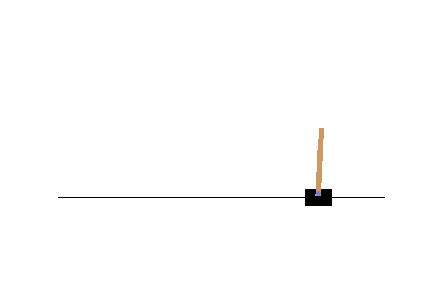
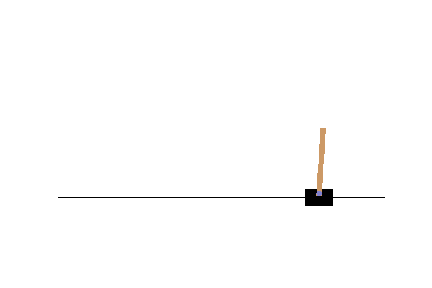
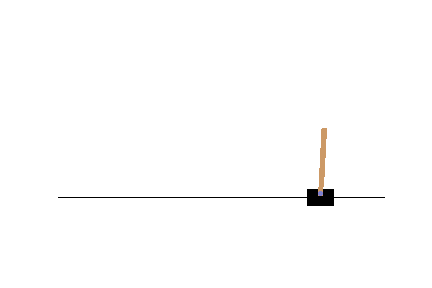
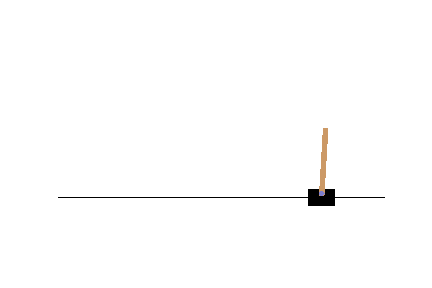
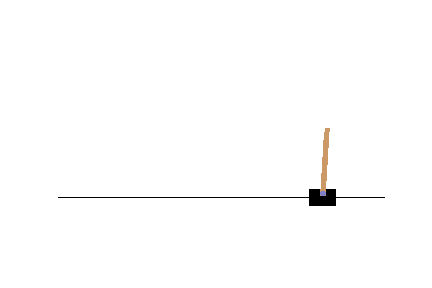
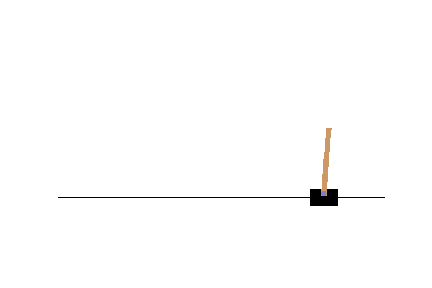
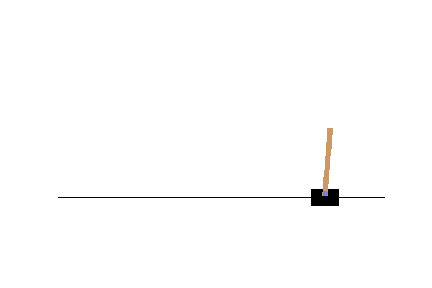
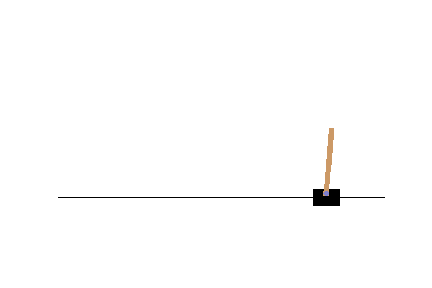
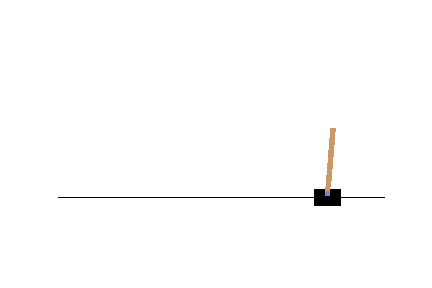
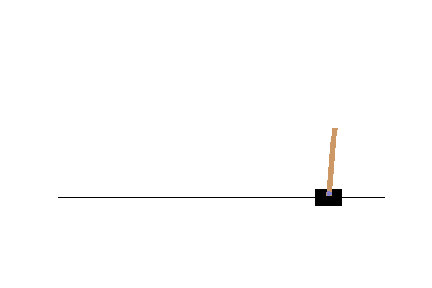
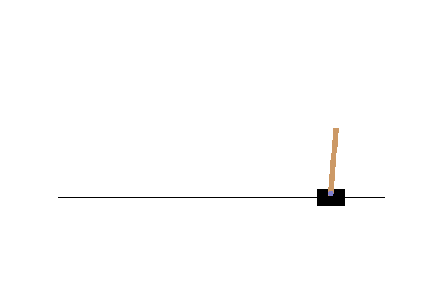
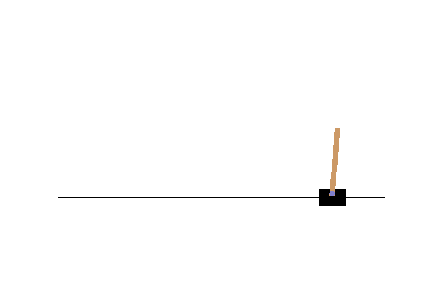
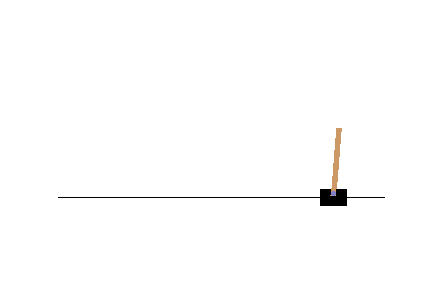
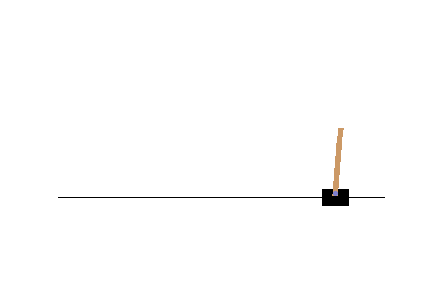
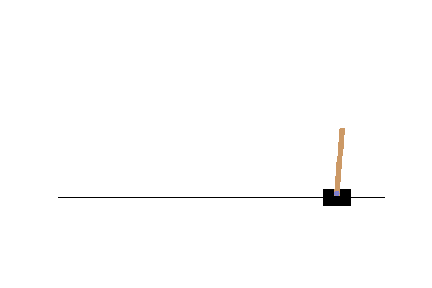
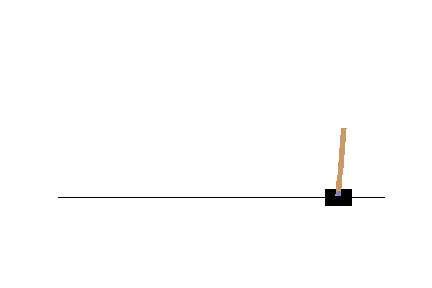
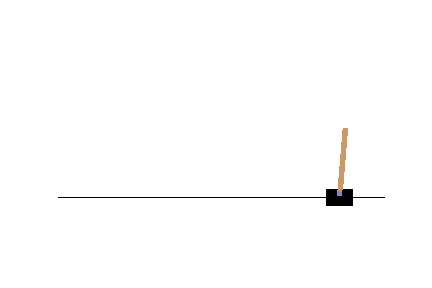
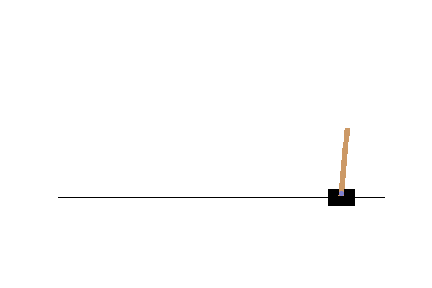
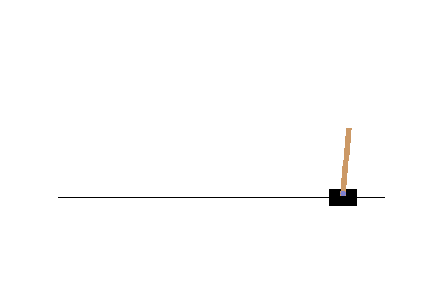
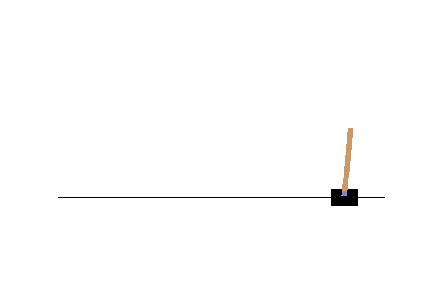
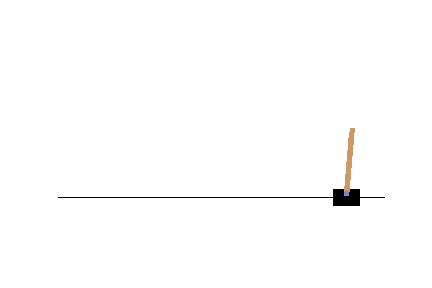
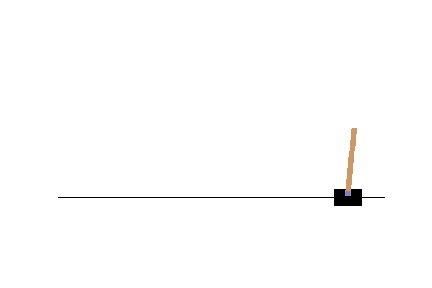
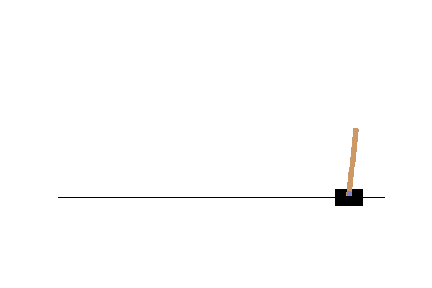
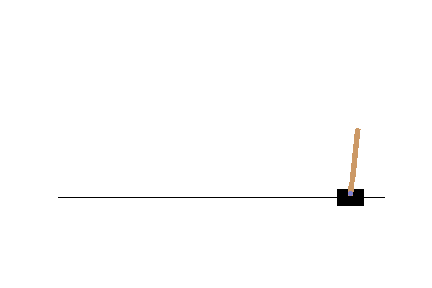
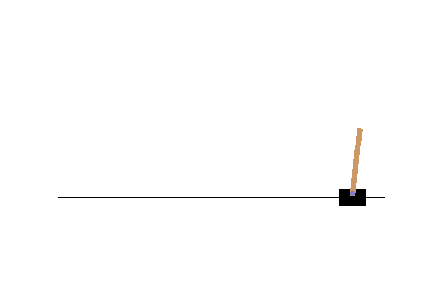
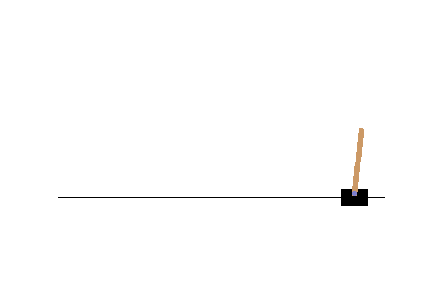
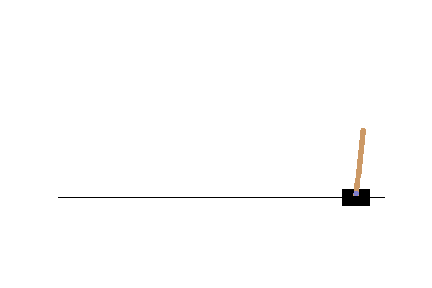
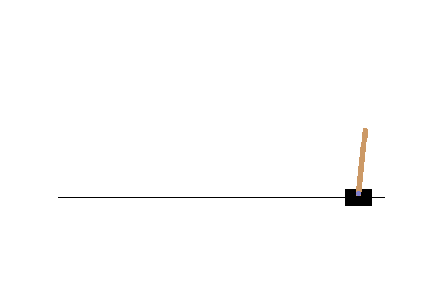
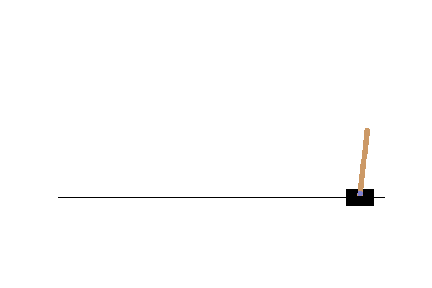
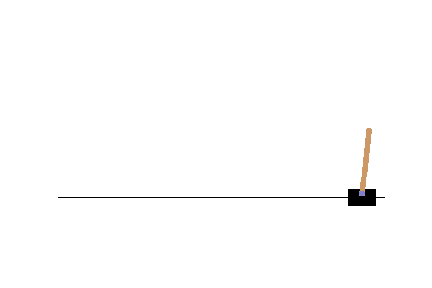
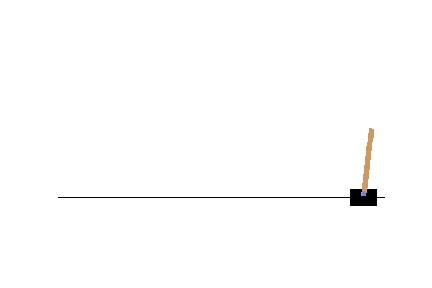
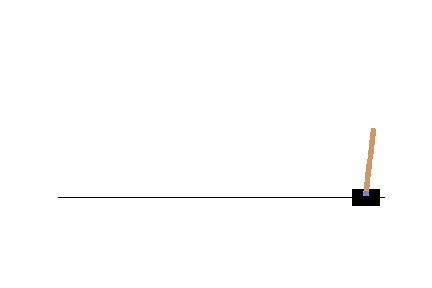
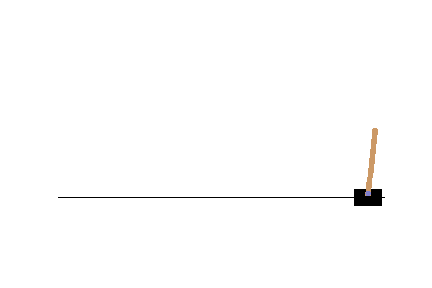
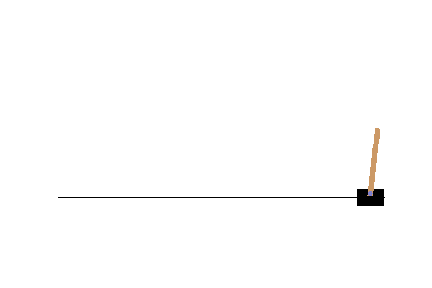
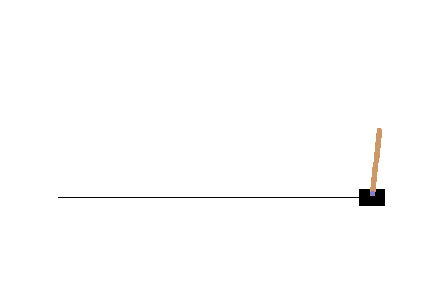
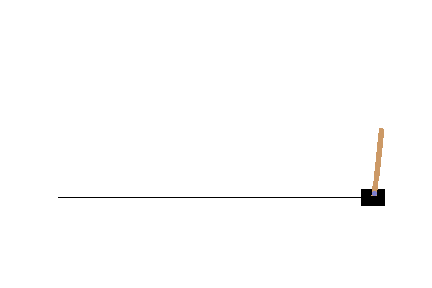
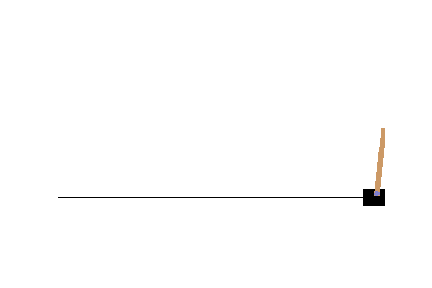
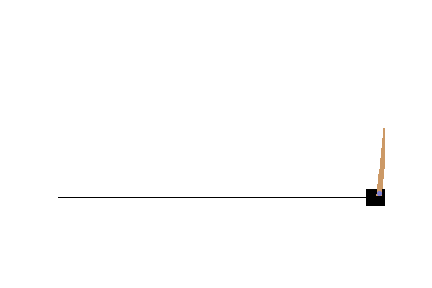
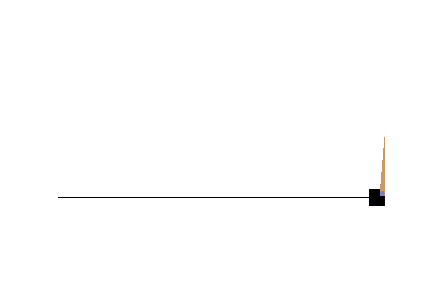
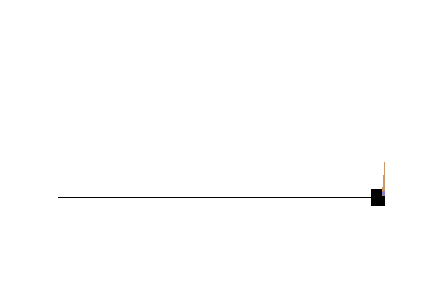

Total reward: 294.0


In [11]:
make_movie(device, env_name, agent)